# SCENIC+ Analysis 
Adapted from https://scenicplus.readthedocs.io/en/latest/pbmc_multiome_tutorial.html

# Step 0: cisTopic analysis

Adapted from https://pycistopic.readthedocs.io/en/latest/Toy_melanoma-RTD.html

## 0.0 Set up directories & dependencies 

In [27]:
# Import packages and functions 
import pycisTopic
from pycisTopic.cistopic_class import *
import pandas as pd
import os
import pickle

In [28]:
# Set the project directory path
proj_dir = '/gpfs1/home/t/s/tsoleary/projects/heater/'

# Set the working directory path
work_dir = os.path.join(proj_dir, 'data/processed/scenic/')
    
# Temp dir
tmp_dir = '/gpfs2/scratch/tsoleary/'

## 0.1 Create cisTopic object

In [29]:
# Load count_matrix
fragment_matrix = pd.read_csv(
    os.path.join(work_dir, 'peaks_matrix.csv'), 
    index_col = 0
)

# Create cisTopic_obj from fragment_matrix
cisTopic_obj = create_cistopic_object(
    fragment_matrix
)

2023-12-15 12:31:17,176 cisTopic     INFO     Converting fragment matrix to sparse matrix
2023-12-15 12:31:18,389 cisTopic     INFO     Creating CistopicObject
2023-12-15 12:31:18,780 cisTopic     INFO     Done!


In [30]:
# Load meta_data
meta_data = pd.read_csv(
    os.path.join(work_dir, 'meta_data.csv'), 
    index_col = 0
)

# Add meta data from Seurat analysis
cisTopic_obj.add_cell_data(meta_data)

## 0.2 Run models

In [31]:
# Run models
models = run_cgs_models(
    cisTopic_obj,
    n_topics = [2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
    n_cpu = 24,
    n_iter = 500,
    random_state = 555,
    alpha = 50,
    alpha_by_topic = True,
    eta = 0.1,
    eta_by_topic = False,
    save_path = None
)

2023-12-15 12:31:21,294	INFO worker.py:1664 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


(run_cgs_model pid=72051) 2023-12-15 12:31:23,490 cisTopic     INFO     Running model with 10 topics
(run_cgs_model pid=72071) 2023-12-15 12:37:26,178 cisTopic     INFO     Model with 2 topics done!
(run_cgs_model pid=72036) 2023-12-15 12:31:23,790 cisTopic     INFO     Running model with 50 topics [repeated 10x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(run_cgs_model pid=72069) 2023-12-15 12:42:54,573 cisTopic     INFO     Model with 5 topics done!
(run_cgs_model pid=72051) 2023-12-15 12:50:20,381 cisTopic     INFO     Model with 10 topics done!
(run_cgs_model pid=72028) 2023-12-15 12:56:48,170 cisTopic     INFO     Model with 15 topics done!
(run_cgs_model pid=72027) 2023-12-15 13:03:01,376 cisTopic     INFO     Model with 20 topics done!
(run_cgs_model pid=72059) 2023-12-15 13:09:19,057 cisTopic     INFO     Model wi

## 0.3 Model selection

In [32]:
# Create directory for figures
fig_dir = os.path.join(proj_dir, 'output/figs/cisTopic')
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

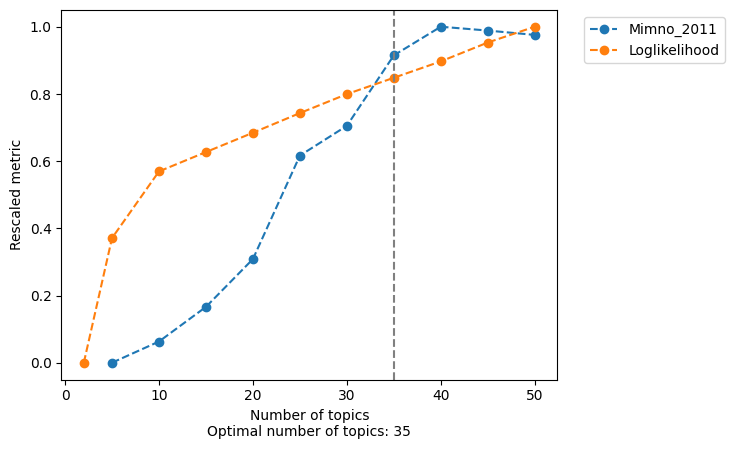

In [33]:
# Evaluate the models
model = evaluate_models(
    models,
    select_model = 35,
    return_model = True,
    metrics = ['Minmo_2011', 'loglikelihood'],
    plot_metrics = False,
    save = os.path.join(fig_dir, 'model_selection.pdf')
)

In [34]:
# Add model to cisTopicObject
cisTopic_obj.add_LDA_model(model)

In [35]:
# Write output files
with open(os.path.join(work_dir, 'cisTopic_obj_00.pkl'), 'wb') as outfile:
    pickle.dump(cisTopic_obj, outfile)

## 0.4 Clustering & visualization

In [36]:
# Import packages and functions 
import pycisTopic
from pycisTopic.cistopic_class import *
import os
import pickle

In [37]:
# Set the project directory path
proj_dir = '/gpfs1/home/t/s/tsoleary/projects/heater/'

# Set the working directory path
work_dir = os.path.join(proj_dir, 'data/processed/scenic/')

# Set the figure output directory
fig_dir = os.path.join(proj_dir, 'output/figs/cisTopic')
    
# Temp dir
tmp_dir = '/gpfs2/scratch/tsoleary/'

In [38]:
# Load cisTopic object
with open(os.path.join(work_dir, 'cisTopic_obj_00.pkl'), 'rb') as infile:
    cisTopic_obj = pickle.load(infile)

In [39]:
# Cluster the cisTopic results
from pycisTopic.clust_vis import find_clusters
find_clusters(cisTopic_obj,
                 target  = 'cell',
                 k = 10,
                 res = [0.6],
                 prefix = 'pycisTopic_',
                 scale = True,
                 split_pattern = '-')

2023-12-15 13:41:10,140 cisTopic     INFO     Finding neighbours


In [40]:
# Run UMAP
from pycisTopic.clust_vis import run_umap
run_umap(
    cisTopic_obj,
    target = 'cell', 
    scale = True
)

2023-12-15 13:41:12,745 cisTopic     INFO     Running UMAP


/users/t/s/tsoleary/anaconda3/envs/scenicplus/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [41]:
# Run t-SNE
from pycisTopic.clust_vis import run_tsne
run_tsne(
    cisTopic_obj,
    target = 'cell',
    scale = True
)

2023-12-15 13:41:22,437 cisTopic     INFO     Running TSNE


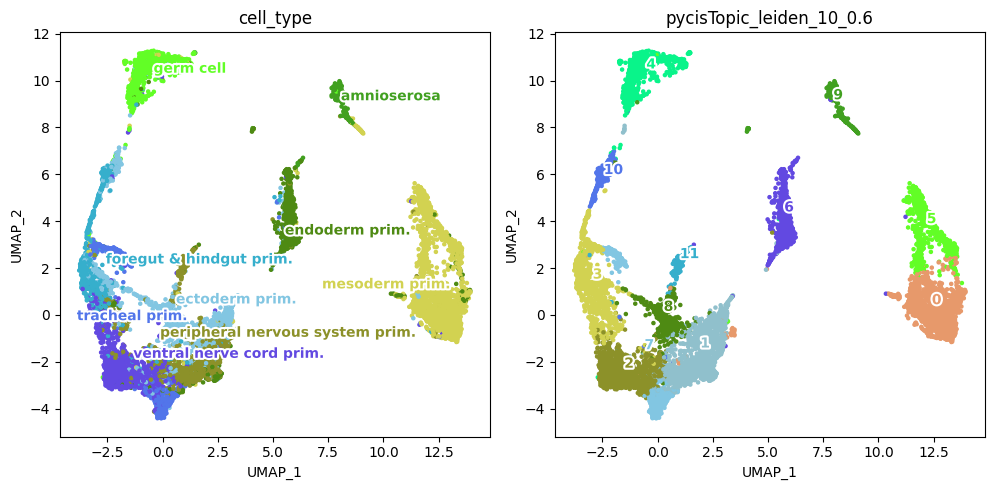

In [42]:
# Plot all meta data
from pycisTopic.clust_vis import plot_metadata
plot_metadata(
    cisTopic_obj,
    reduction_name = 'UMAP',
    variables = ['cell_type', 'pycisTopic_leiden_10_0.6'],
    target = 'cell', 
    num_columns = 3,
    text_size = 10,
    dot_size = 5,
    figsize = (15,5),
    save = os.path.join(fig_dir, 'dimensionality_reduction_label.pdf')
)

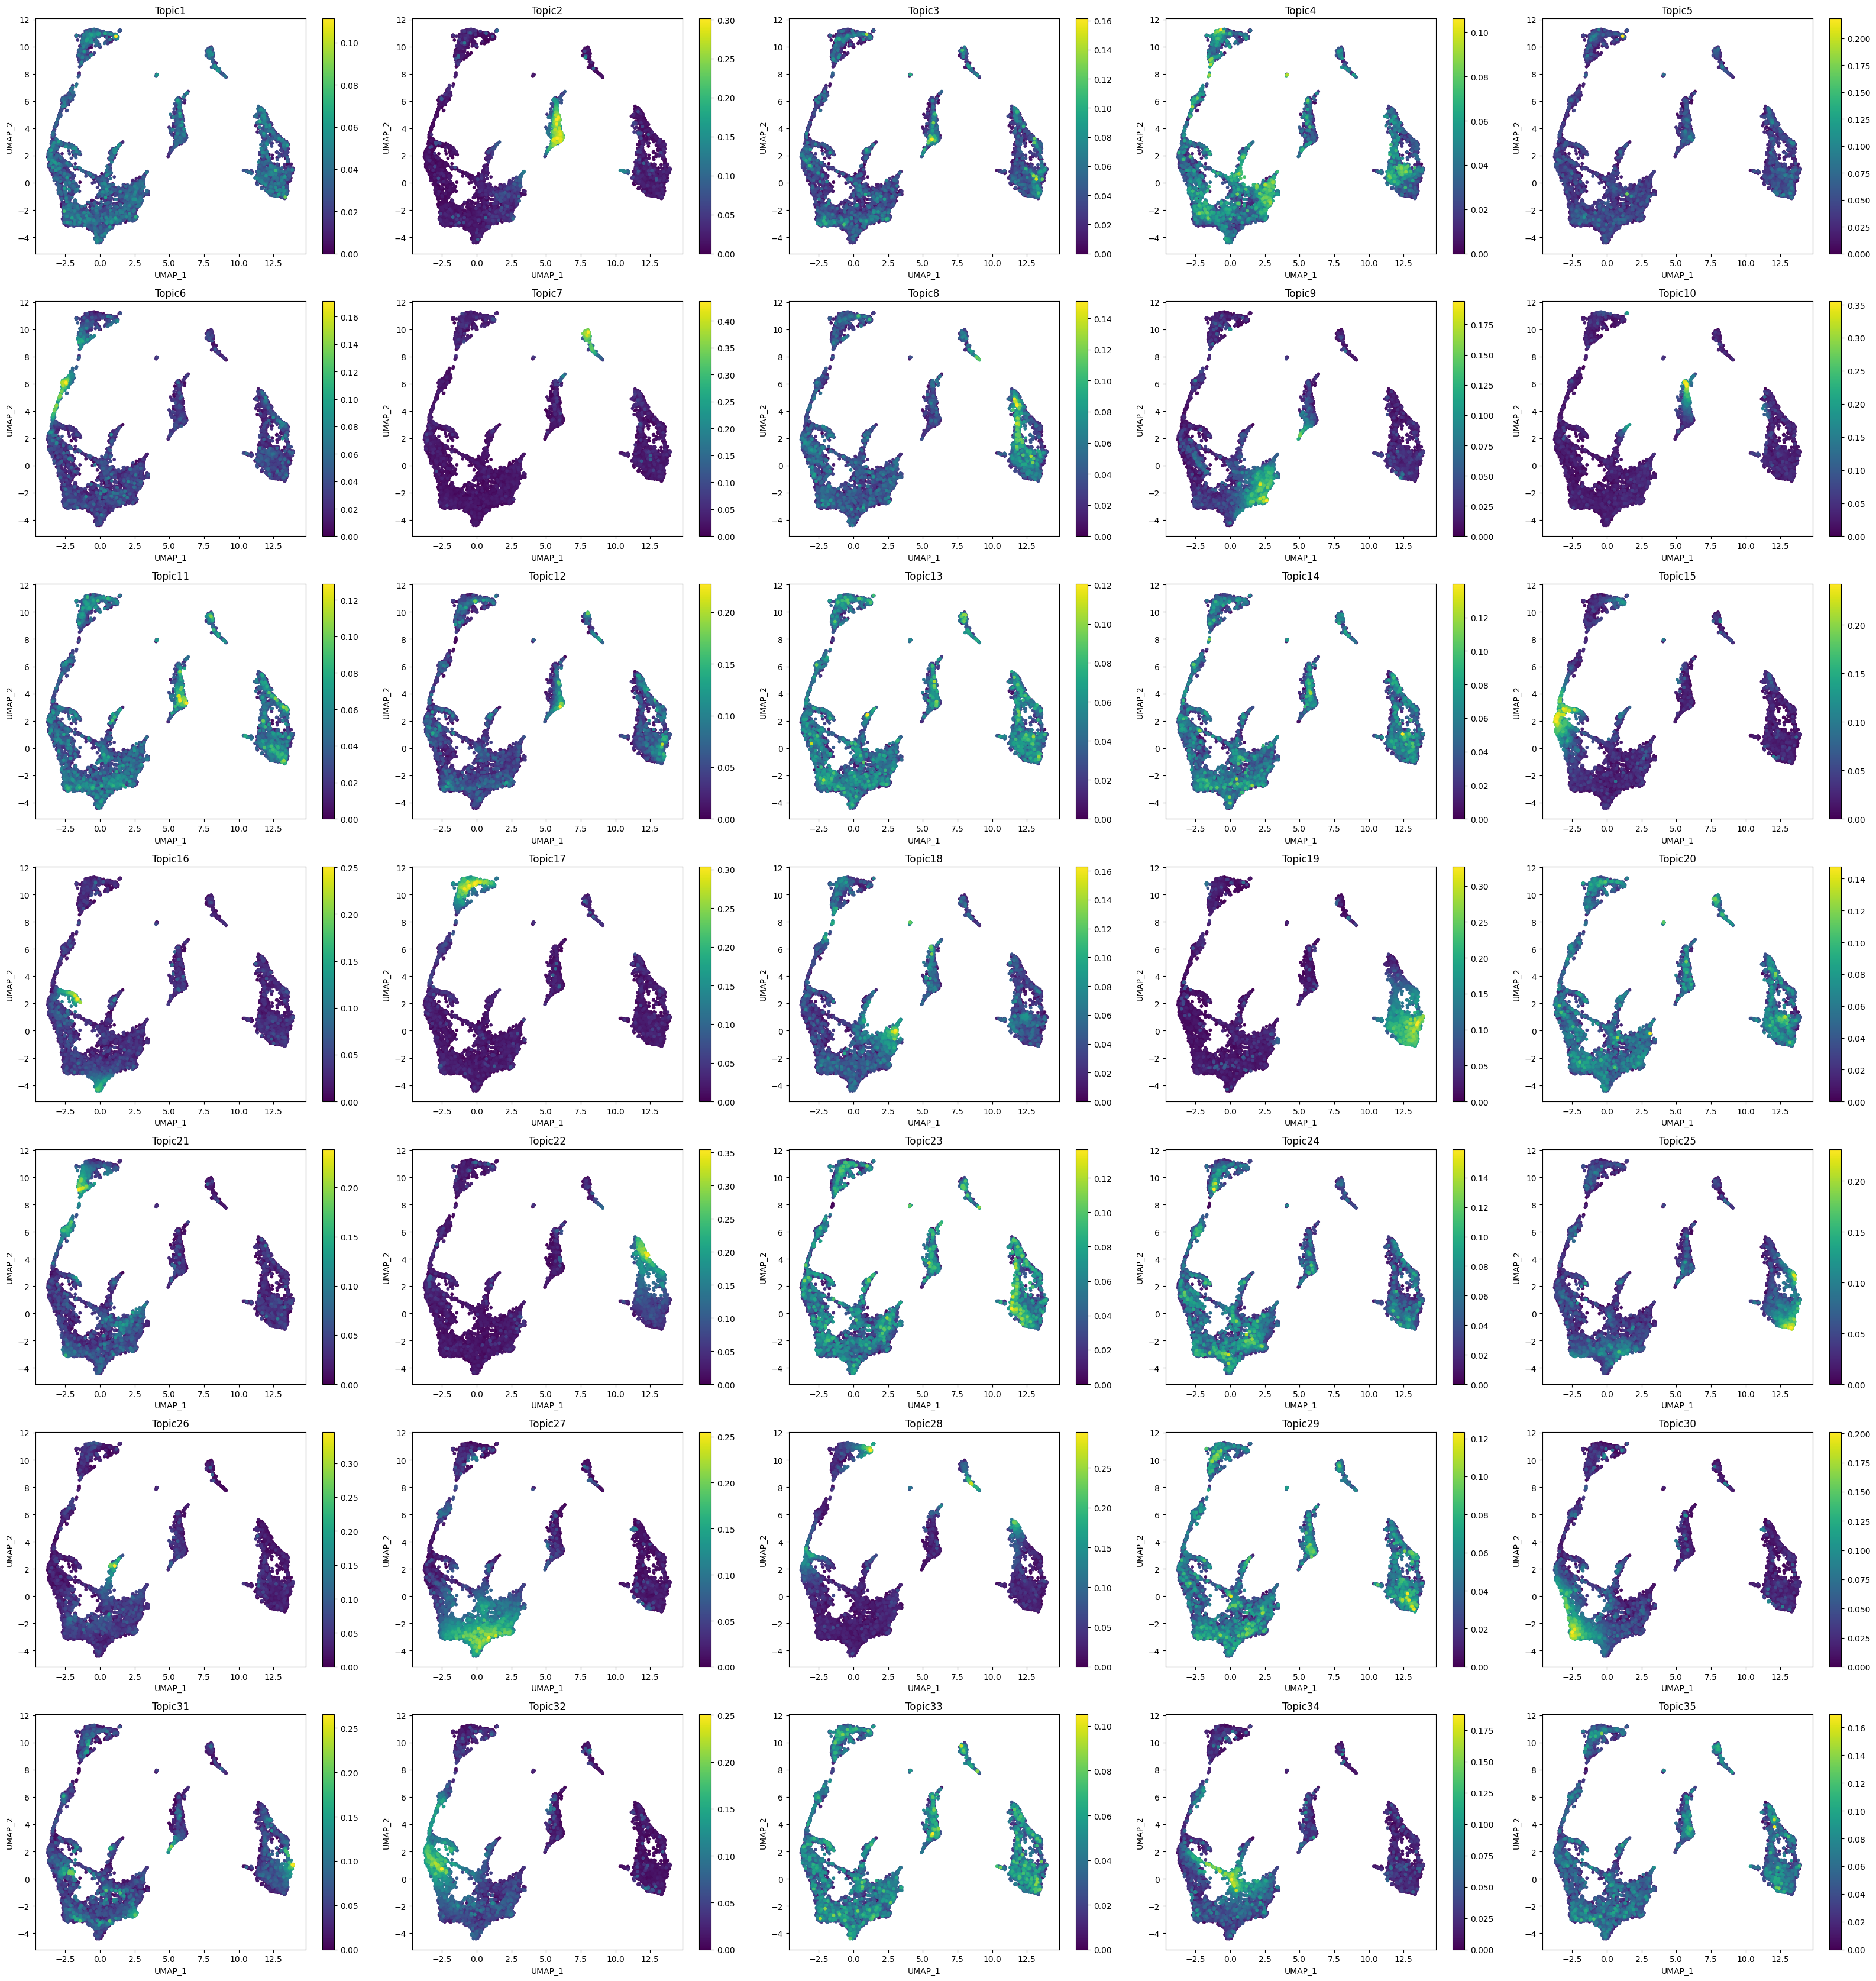

In [43]:
# Plot topic contributions onto UMAP
from pycisTopic.clust_vis import plot_topic
plot_topic(
    cisTopic_obj,
    reduction_name = 'UMAP',
    target = 'cell',
    num_columns = 5,
    save = os.path.join(fig_dir, 'dimensionality_reduction_topic_contr.pdf')
)

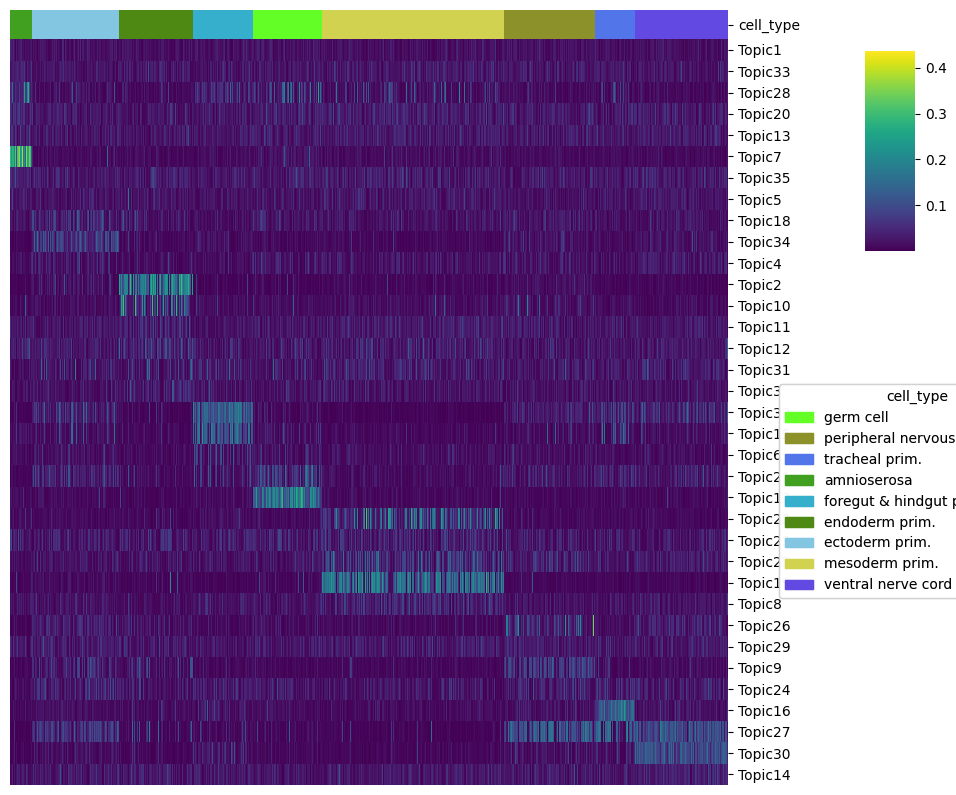

In [44]:
# Plot topic contributions onto heatmap with cell-type
from pycisTopic.clust_vis import cell_topic_heatmap
cell_topic_heatmap(
    cisTopic_obj,
    variables = ['cell_type'],
    scale = False,
    legend_loc_x = 1.05,
    legend_loc_y = -1.2,
    legend_dist_y = -1,
    figsize = (10, 10),
    save = os.path.join(fig_dir, 'heatmap_topic_contr.pdf')
)

In [45]:
# Save cisTopic_obj with UMAP and t-SNE dimensional reductions added
with open(work_dir + 'cisTopic_obj_01.pkl', 'wb') as f:
  pickle.dump(cisTopic_obj, f)

## 0.5 Topic binarization & QC

In [46]:
# Import packages and functions 
import pycisTopic
from pycisTopic.cistopic_class import *
import os
import pickle

In [47]:
# Set the project directory path
proj_dir = '/gpfs1/home/t/s/tsoleary/projects/heater/'

# Set the working directory path
work_dir = os.path.join(proj_dir, 'data/processed/scenic/')

# Set the figure output directory
fig_dir = os.path.join(proj_dir, 'output/figs/cisTopic')
    
# Temp dir
tmp_dir = '/gpfs2/scratch/tsoleary/'

In [48]:
# Load cisTopic object
import pickle
with open(os.path.join(work_dir, 'cisTopic_obj_01.pkl'), 'rb') as infile:
    cisTopic_obj = pickle.load(infile)

In [49]:
# Create directory for the output
out_dir = os.path.join(work_dir, 'topic_binarization')
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

In [50]:
# Import binarizarion functions
from pycisTopic.topic_binarization import *

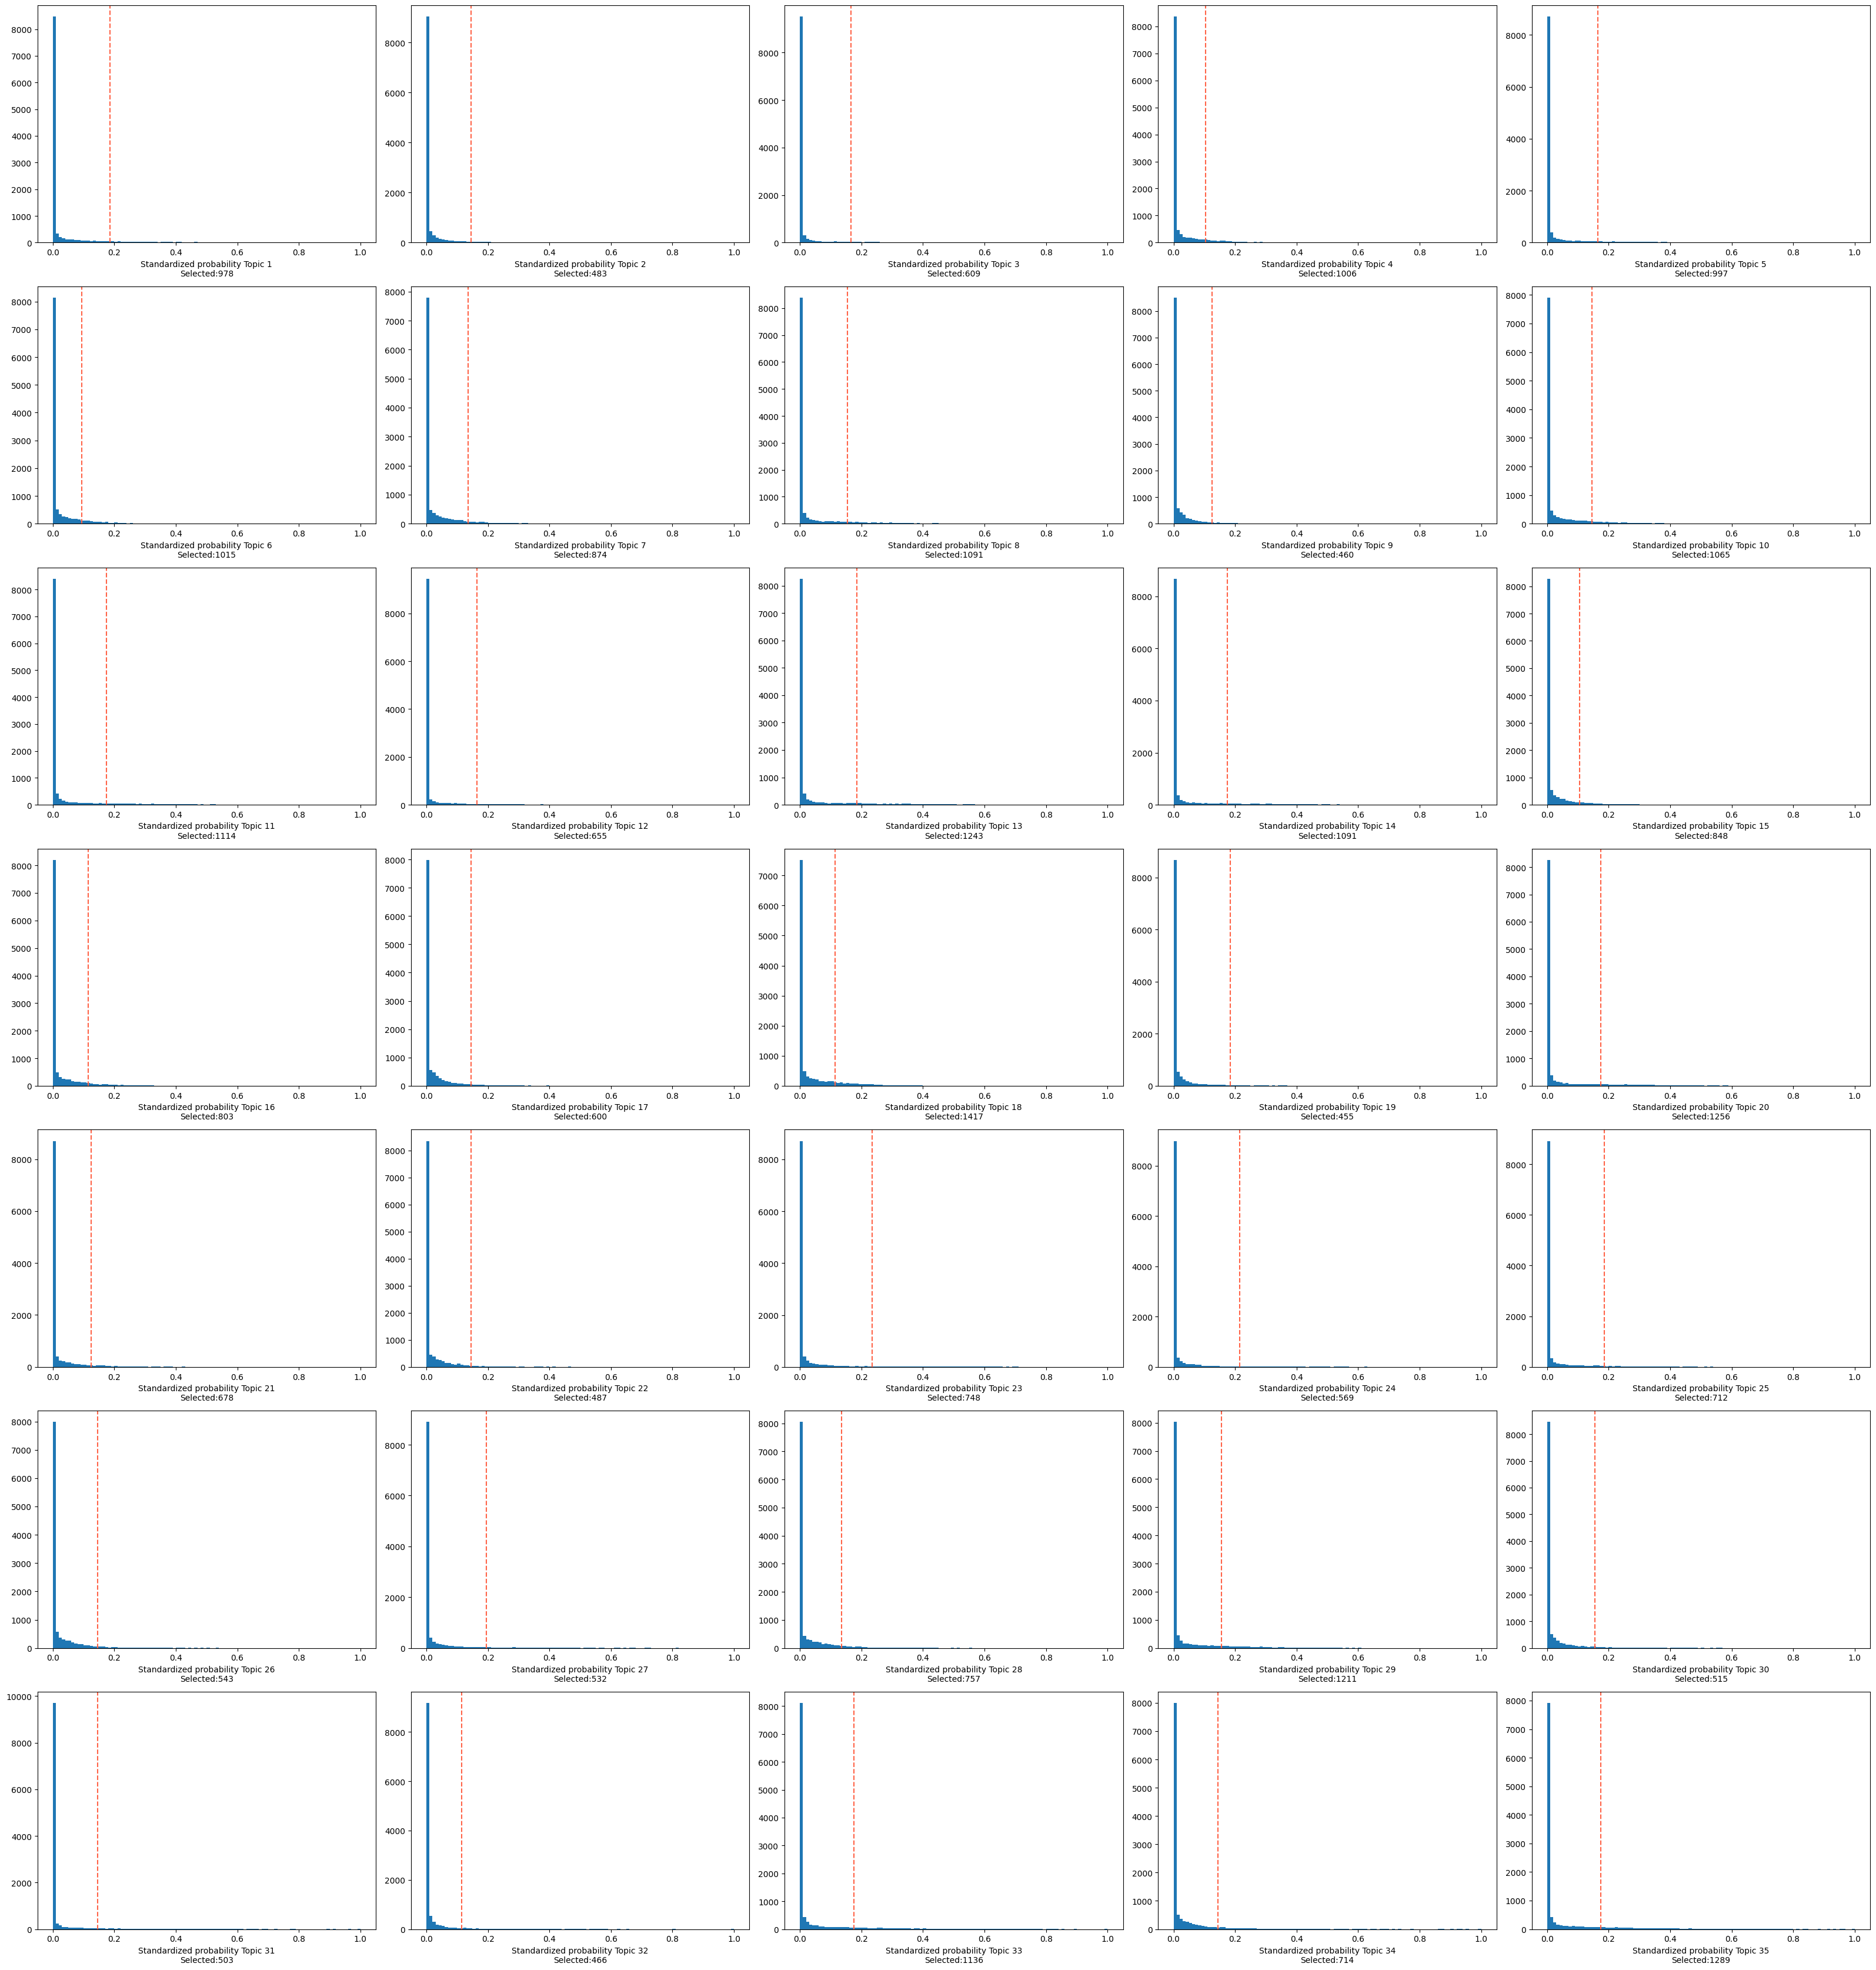

In [51]:
# Binarize region topics
region_bin_topics = binarize_topics(
    cisTopic_obj, 
    method = 'otsu', 
    ntop = 3000, 
    plot = True, 
    num_columns = 5, 
    save = os.path.join(fig_dir, 'otsu_region_bin_topics.pdf')
)

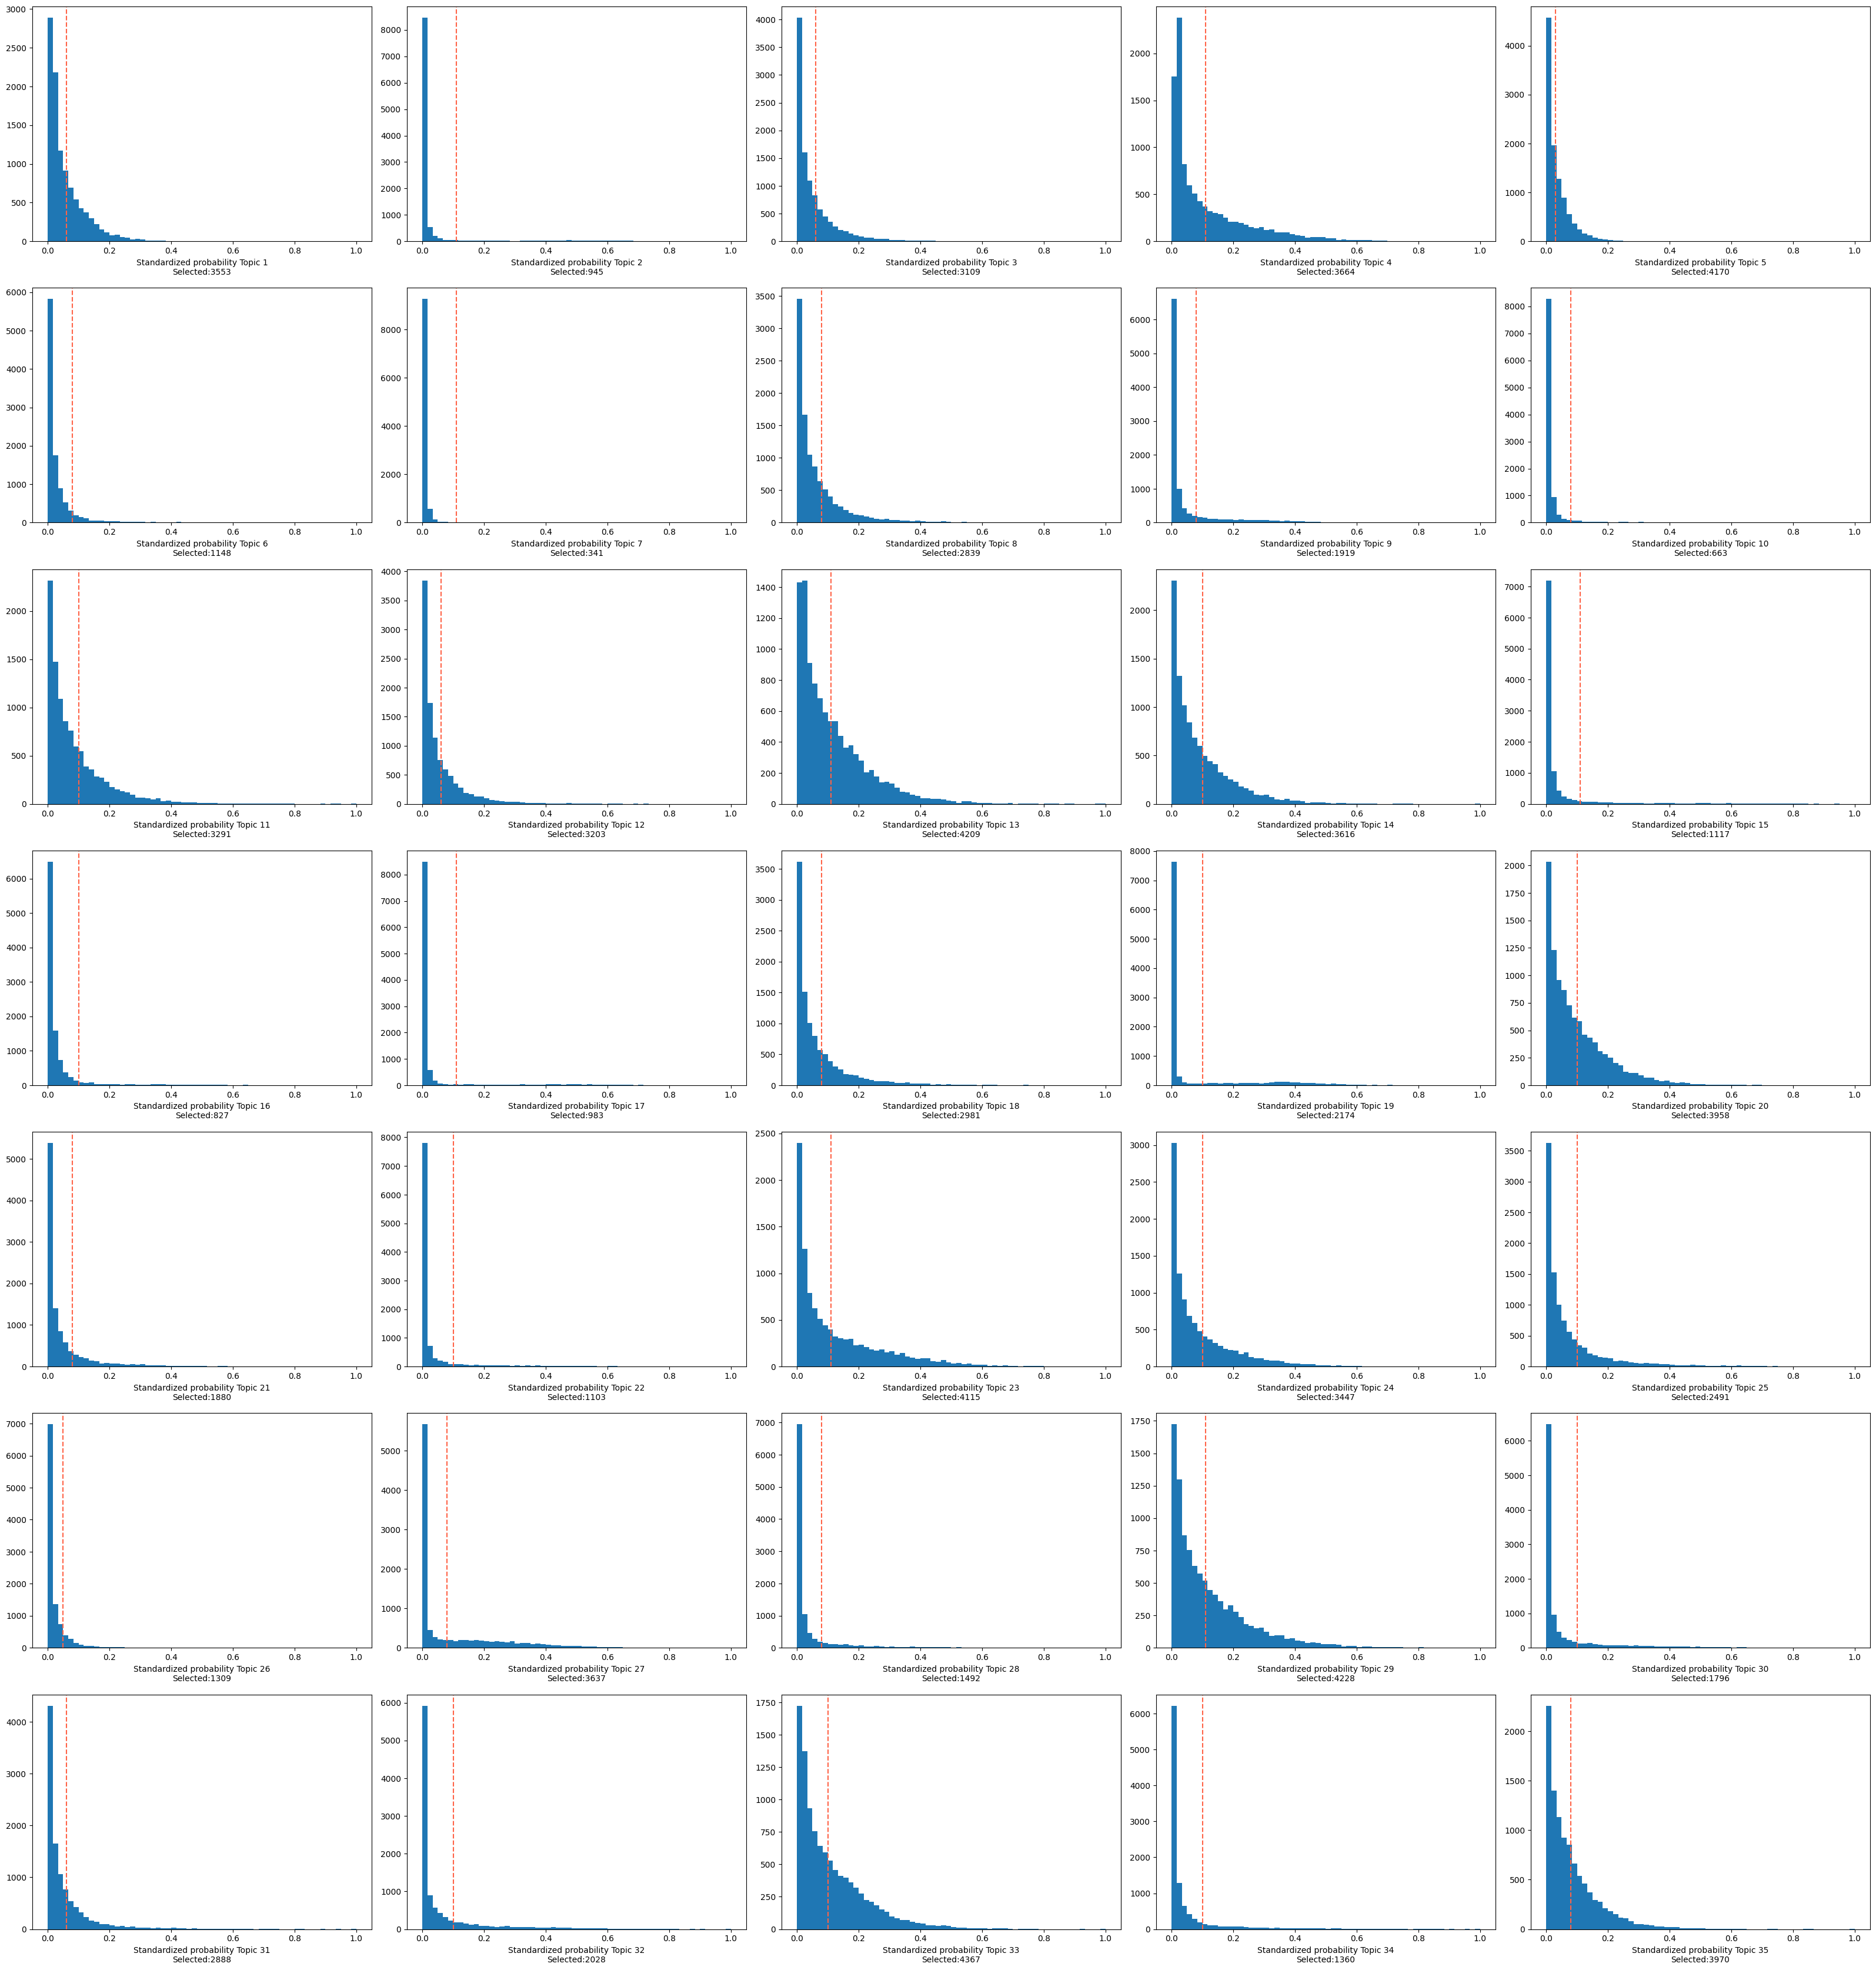

In [52]:
# Binarize the cell topics
binarized_cell_topic = binarize_topics(
    cisTopic_obj, 
    target = 'cell', 
    method = 'li', 
    plot = True, 
    num_columns = 5, 
    nbins = 60,
    save = os.path.join(fig_dir, 'binarized_cell_topic.pdf')
)

Calculate Topic quality control metrics

In [53]:
# Calc QC metrics
from pycisTopic.topic_qc import *
topic_qc_metrics = compute_topic_metrics(cisTopic_obj)

In [54]:
# Create dictionary of figures to loop through
fig_dict = {}
fig_dict['CoherenceVSAssignments'] = plot_topic_qc(
    topic_qc_metrics, 
    var_x = 'Coherence', 
    var_y = 'Log10_Assignments', 
    var_color = 'Gini_index', 
    plot = False, 
    return_fig = True
)
fig_dict['AssignmentsVSCells_in_bin'] = plot_topic_qc(
    topic_qc_metrics, 
    var_x = 'Log10_Assignments', 
    var_y = 'Cells_in_binarized_topic', 
    var_color = 'Gini_index', 
    plot = False, 
    return_fig = True
)
fig_dict['CoherenceVSCells_in_bin'] = plot_topic_qc(
    topic_qc_metrics, 
    var_x = 'Coherence',
    var_y = 'Cells_in_binarized_topic',
    var_color = 'Gini_index',
    plot = False,
    return_fig = True
)
fig_dict['CoherenceVSRegions_in_bin'] = plot_topic_qc(
    topic_qc_metrics, 
    var_x = 'Coherence', 
    var_y = 'Regions_in_binarized_topic', 
    var_color = 'Gini_index', 
    plot = False, 
    return_fig = True
)
fig_dict['CoherenceVSMarginal_dist'] = plot_topic_qc(
    topic_qc_metrics, 
    var_x = 'Coherence', 
    var_y = 'Marginal_topic_dist', 
    var_color = 'Gini_index', 
    plot = False, 
    return_fig = True
)
fig_dict['CoherenceVSGini_index'] = plot_topic_qc(
    topic_qc_metrics, 
    var_x = 'Coherence', 
    var_y = 'Gini_index', 
    var_color = 'Gini_index', 
    plot = False, 
    return_fig = True
)

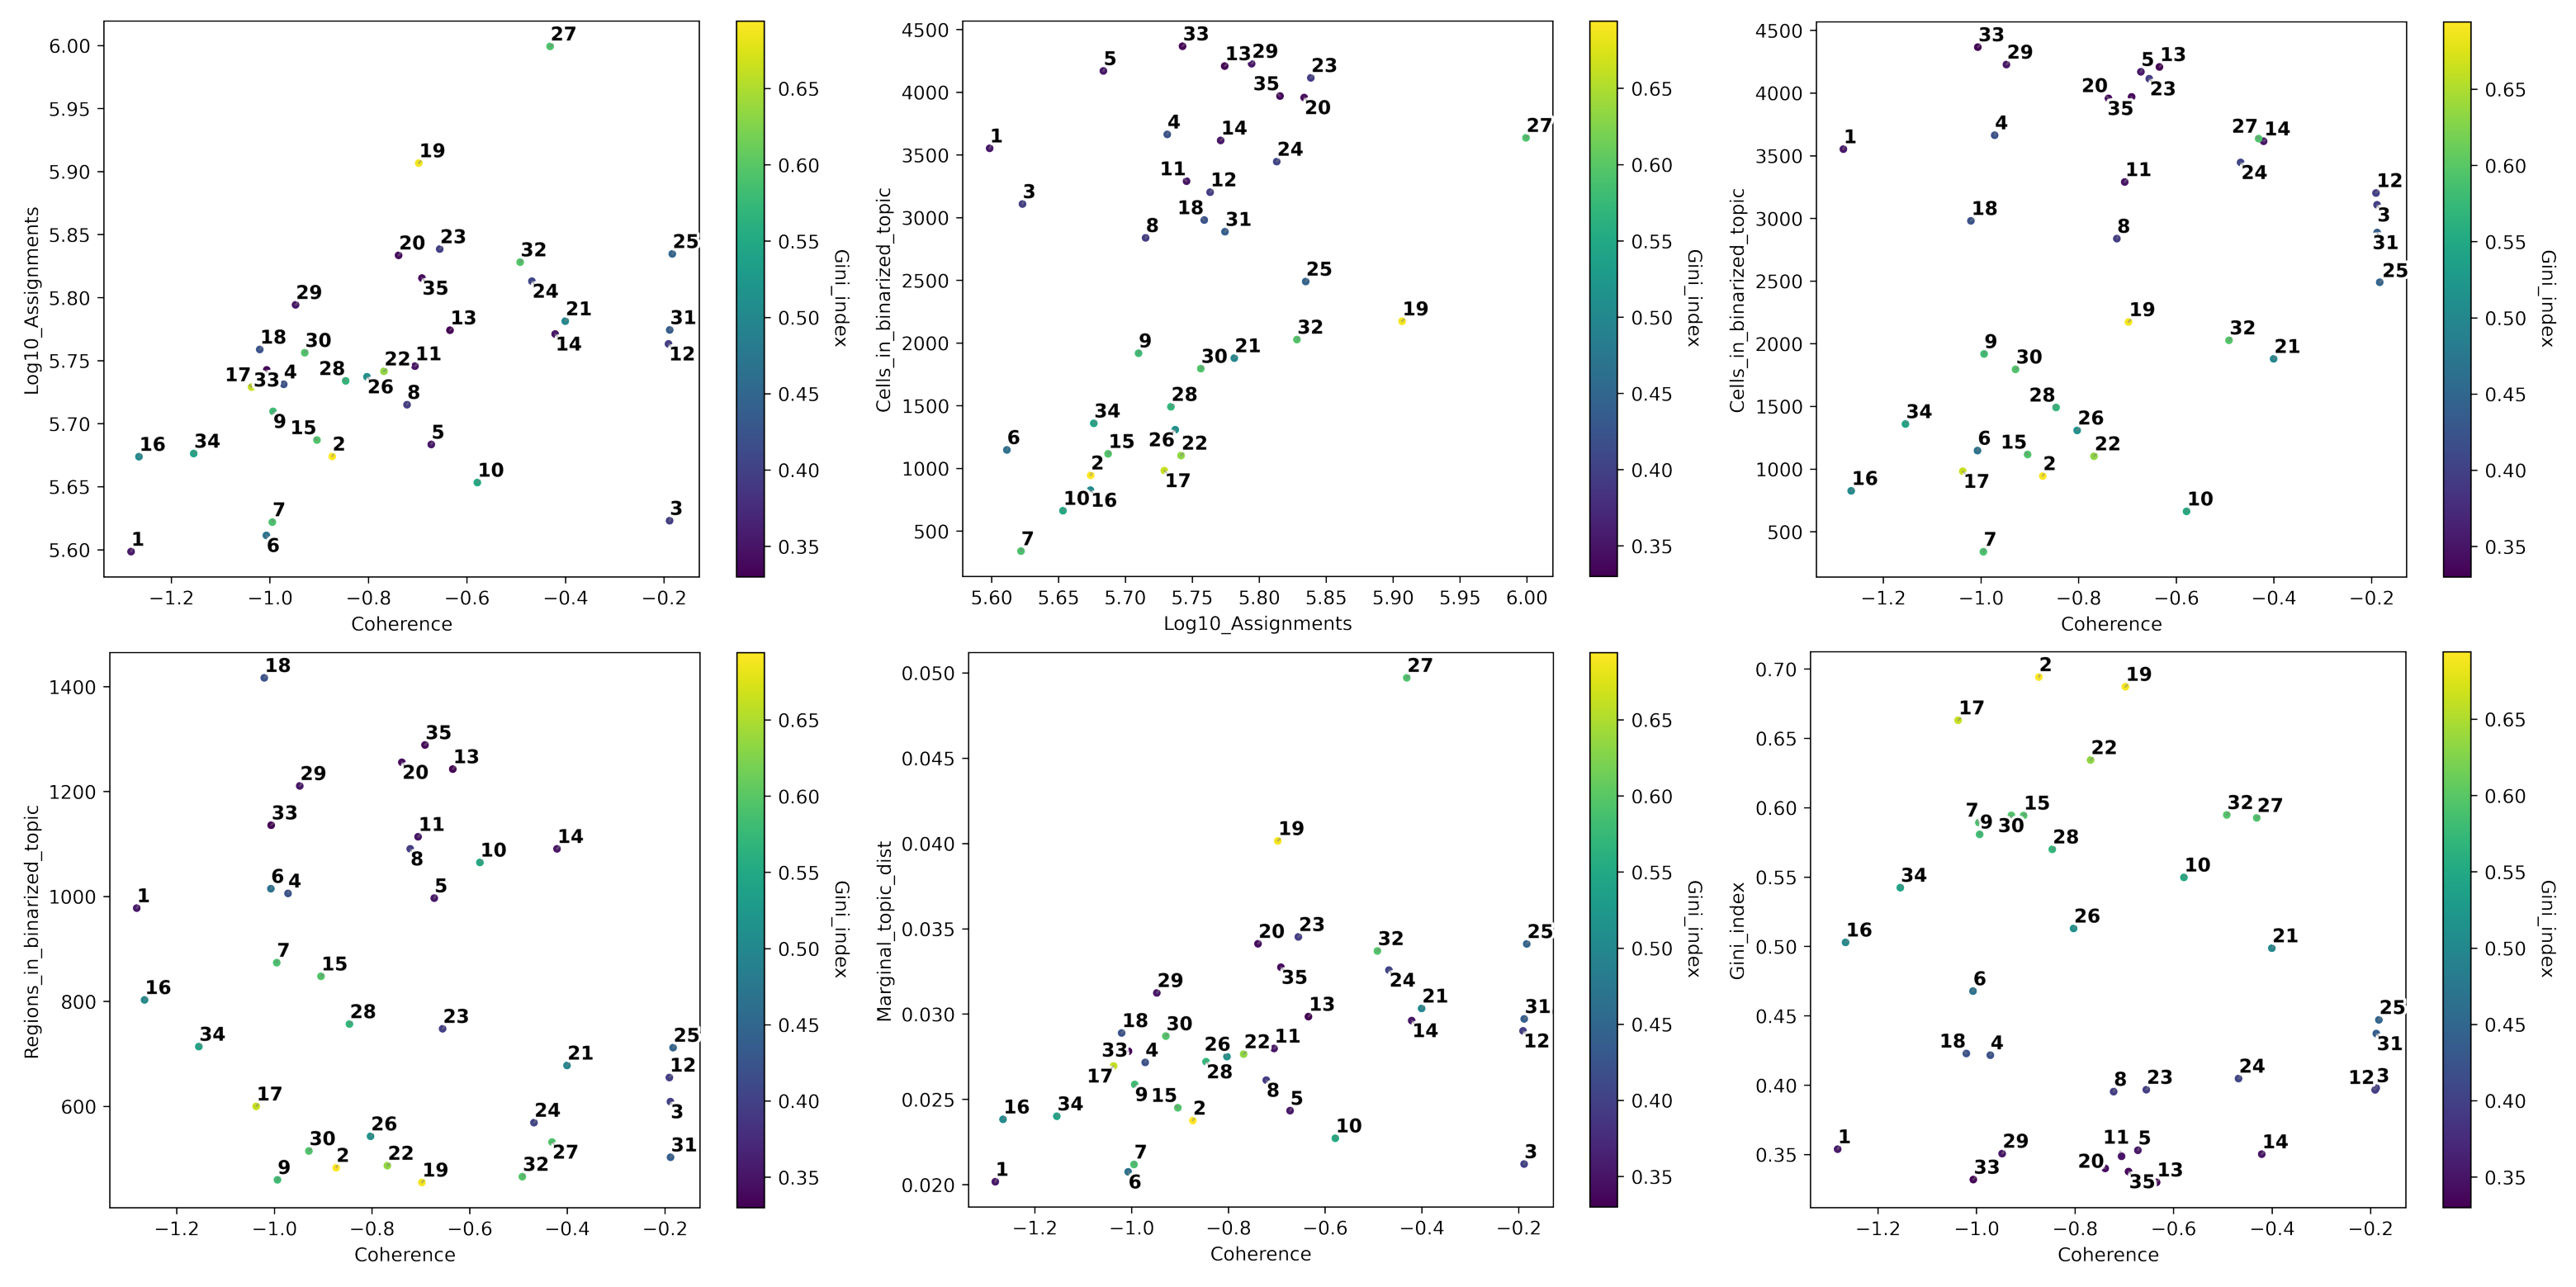

In [55]:
# Plot topic stats in one figure
fig = plt.figure(figsize = (40, 43))
i = 1
for fig_ in fig_dict.keys():
    plt.subplot(2, 3, i)
    img = fig2img(fig_dict[fig_])
    plt.imshow(img)
    plt.axis('off')
    i += 1
plt.subplots_adjust(
    wspace = 0, 
    hspace = -0.70
)
fig.savefig(
    os.path.join(fig_dir, 'topic_qc.pdf'), 
    bbox_inches = 'tight'
)
plt.show()

In [56]:
topic_annot = topic_annotation(
    cisTopic_obj, 
    annot_var = 'cell_type', 
    binarized_cell_topic = binarized_cell_topic, 
    general_topic_thr = 0.2
)
topic_annot

/users/t/s/tsoleary/anaconda3/envs/scenicplus/lib/python3.8/site-packages/statsmodels/stats/weightstats.py:792: RuntimeWarning: divide by zero encountered in scalar divide
  zstat = value / std


cell_type  \
Topic1                              germ cell, amnioserosa   
Topic2                                      endoderm prim.   
Topic3         amnioserosa, endoderm prim., mesoderm prim.   
Topic4   peripheral nervous system prim., ectoderm prim...   
Topic5         amnioserosa, endoderm prim., mesoderm prim.   
Topic6                  germ cell, foregut & hindgut prim.   
Topic7                                         amnioserosa   
Topic8                         amnioserosa, mesoderm prim.   
Topic9   peripheral nervous system prim., endoderm prim...   
Topic10                                     endoderm prim.   
Topic11        amnioserosa, endoderm prim., mesoderm prim.   
Topic12  germ cell, amnioserosa, endoderm prim., mesode...   
Topic13                        amnioserosa, mesoderm prim.   
Topic14  endoderm prim., mesoderm prim., ventral nerve ...   
Topic15            tracheal prim., foregut & hindgut prim.   
Topic16                                     tracheal prim.   
Topic17                                          germ cell   
Topic18  peripheral nervous system prim., endoderm prim...   
Topic19                                     mesoderm prim.   
Topic20  germ cell, amnioserosa, mesoderm prim., ventra...   
Topic21  germ cell, tracheal prim., foregut & hindgut p...   
Topic22                                     mesoderm prim.   
Topic23             germ cell, amnioserosa, mesoderm prim.   
Topic24  peripheral nervous system prim., tracheal prim...   
Topic25                                     mesoderm prim.   
Topic26  peripheral nervous system prim., ectoderm prim...   
Topic27  peripheral nervous system prim., tracheal prim...   
Topic28  germ cell, tracheal prim., amnioserosa, foregu...   
Topic29  germ cell, peripheral nervous system prim., am...   
Topic30  foregut & hindgut prim., ventral nerve cord prim.   
Topic31            foregut & hindgut prim., mesoderm prim.   
Topic32  tracheal prim., foregut & hindgut prim., ectod...   
Topic33  germ cell, amnioserosa, endoderm prim., mesode...   
Topic34    peripheral nervous system prim., ectoderm prim.   
Topic35        amnioserosa, endoderm prim., mesoderm prim.   

        Ratio_cells_in_topic Ratio_group_in_population  is_general  
Topic1              0.341963                  0.127623        True  
Topic2              0.090953                  0.103657       False  
Topic3               0.29923                  0.386429       False  
Topic4              0.352647                  0.379115       False  
Topic5              0.401347                  0.386429       False  
Topic6              0.110491                  0.179596       False  
Topic7               0.03282                   0.03051       False  
Topic8              0.273244                  0.282772       False  
Topic9              0.184697                  0.352262       False  
Topic10             0.063811                  0.103657       False  
Topic11             0.316747                  0.386429       False  
Topic12             0.308277                  0.483542       False  
Topic13             0.405101                  0.282772       False  
Topic14             0.348027                  0.486429       False  
Topic15             0.107507                  0.137344       False  
Topic16             0.079596                   0.05486       False  
Topic17              0.09461                  0.097113       False  
Topic18              0.28691                  0.352262       False  
Topic19              0.20924                  0.252262       False  
Topic20             0.380943                  0.510395       False  
Topic21             0.180943                  0.355534       False  
Topic22              0.10616                  0.252262       False  
Topic23             0.396054                  0.379885       False  
Topic24             0.331761                  0.433975       False  
Topic25              0.23975                  0.252262       False  
Topic26             0.

In [57]:
topic_qc_metrics = pd.concat(
    [topic_annot[['cell_type', 'Ratio_cells_in_topic', 'Ratio_group_in_population']], 
     topic_qc_metrics], 
    axis = 1
)
topic_qc_metrics

cell_type  \
Topic1                              germ cell, amnioserosa   
Topic2                                      endoderm prim.   
Topic3         amnioserosa, endoderm prim., mesoderm prim.   
Topic4   peripheral nervous system prim., ectoderm prim...   
Topic5         amnioserosa, endoderm prim., mesoderm prim.   
Topic6                  germ cell, foregut & hindgut prim.   
Topic7                                         amnioserosa   
Topic8                         amnioserosa, mesoderm prim.   
Topic9   peripheral nervous system prim., endoderm prim...   
Topic10                                     endoderm prim.   
Topic11        amnioserosa, endoderm prim., mesoderm prim.   
Topic12  germ cell, amnioserosa, endoderm prim., mesode...   
Topic13                        amnioserosa, mesoderm prim.   
Topic14  endoderm prim., mesoderm prim., ventral nerve ...   
Topic15            tracheal prim., foregut & hindgut prim.   
Topic16                                     tracheal prim.   
Topic17                                          germ cell   
Topic18  peripheral nervous system prim., endoderm prim...   
Topic19                                     mesoderm prim.   
Topic20  germ cell, amnioserosa, mesoderm prim., ventra...   
Topic21  germ cell, tracheal prim., foregut & hindgut p...   
Topic22                                     mesoderm prim.   
Topic23             germ cell, amnioserosa, mesoderm prim.   
Topic24  peripheral nervous system prim., tracheal prim...   
Topic25                                     mesoderm prim.   
Topic26  peripheral nervous system prim., ectoderm prim...   
Topic27  peripheral nervous system prim., tracheal prim...   
Topic28  germ cell, tracheal prim., amnioserosa, foregu...   
Topic29  germ cell, peripheral nervous system prim., am...   
Topic30  foregut & hindgut prim., ventral nerve cord prim.   
Topic31            foregut & hindgut prim., mesoderm prim.   
Topic32  tracheal prim., foregut & hindgut prim., ectod...   
Topic33  germ cell, amnioserosa, endoderm prim., mesode...   
Topic34    peripheral nervous system prim., ectoderm prim.   
Topic35        amnioserosa, endoderm prim., mesoderm prim.   

        Ratio_cells_in_topic Ratio_group_in_population  Log10_Assignments  \
Topic1              0.341963                  0.127623           5.598579   
Topic2              0.090953                  0.103657           5.674070   
Topic3               0.29923                  0.386429           5.623093   
Topic4              0.352647                  0.379115           5.731304   
Topic5              0.401347                  0.386429           5.683563   
Topic6              0.110491                  0.179596           5.611444   
Topic7               0.03282                   0.03051           5.621992   
Topic8              0.273244                  0.282772           5.715119   
Topic9              0.184697                  0.352262           5.709835   
Topic10             0.063811                  0.103657           5.653378   
Topic11             0.316747                  0.386429           5.745698   
Topic12             0.308277                  0.483542           5.763334   
Topic13             0.405101                  0.282772           5.774212   
Topic14             0.348027                  0.486429           5.771202   
Topic15             0.107507                  0.137344           5.687113   
Topic16             0.079596                   0.05486           5.673887   
Topic17              0.09461                  0.097113           5.729098   
Topic18              0.28691                  0.352262           5.758937   
Topic19              0.20924                  0.252262           5.906763   
Topic20             0.380943                  0.510395           5.833609   
Topic21             0.180943                  0.355534           5.781392   
Topic22              0.10616                  0.252262           5.741627   
Topic23             0.396054                 

In [58]:
# Save files
with open(os.path.join(out_dir, 'topic_qc_metrics_annot.pkl'), 'wb') as f:
  pickle.dump(topic_qc_metrics, f)
with open(os.path.join(out_dir, 'binarized_cell_topic.pkl'), 'wb') as f:
  pickle.dump(binarized_cell_topic, f)
with open(os.path.join(out_dir, 'binarized_topic_region.pkl'), 'wb') as f:
  pickle.dump(region_bin_topics, f)

## 0.6 Calculate DARs

In [1]:
# Import packages and functions 
import pycisTopic
from pycisTopic.cistopic_class import *
import os
import pickle

In [2]:
# Set the project directory path
proj_dir = '/gpfs1/home/t/s/tsoleary/projects/heater/'

# Set the working directory path
work_dir = os.path.join(proj_dir, 'data/processed/scenic/')

# Set the figure output directory
fig_dir = os.path.join(proj_dir, 'output/figs/cisTopic')
    
# Temp dir
tmp_dir = '/gpfs2/scratch/tsoleary/'

In [3]:
# Load cisTopic object
import pickle
with open(os.path.join(work_dir, 'cisTopic_obj_01.pkl'), 'rb') as infile:
    cisTopic_obj = pickle.load(infile)

In [4]:
from pycisTopic.diff_features import *
imputed_acc_obj = impute_accessibility(
    cisTopic_obj, 
    selected_cells = None, 
    selected_regions = None, 
    scale_factor = 10**6
)
normalized_imputed_acc_obj = normalize_scores(
    imputed_acc_obj, 
    scale_factor = 10**4
)
variable_regions = find_highly_variable_features(
    normalized_imputed_acc_obj, 
    plot = False
)

2023-12-18 09:56:27,326 cisTopic     INFO     Imputing region accessibility
2023-12-18 09:56:27,327 cisTopic     INFO     Impute region accessibility for regions 0-20000
2023-12-18 09:56:28,251 cisTopic     INFO     Done!
2023-12-18 09:56:28,252 cisTopic     INFO     Normalizing imputed data
2023-12-18 09:56:29,826 cisTopic     INFO     Done!
2023-12-18 09:56:29,827 cisTopic     INFO     Calculating mean
2023-12-18 09:56:29,902 cisTopic     INFO     Calculating variance
2023-12-18 09:56:30,645 cisTopic     INFO     Done!


<Figure size 640x480 with 0 Axes>

In [7]:
# Cell-type markers
markers_cell_type = find_diff_features(
    cisTopic_obj, 
    imputed_acc_obj, 
    variable = 'cell_type', 
    var_features = variable_regions,
    log2fc_thr = 0.25,
    split_pattern = '-'
)
# Acclimation temp markers
markers_acc_temp = find_diff_features(
    cisTopic_obj, 
    imputed_acc_obj, 
    variable = 'acc_temp', 
    var_features = variable_regions, 
    log2fc_thr = 0.25,
    split_pattern = '-'
)

2023-12-18 09:59:18,756 cisTopic     INFO     Subsetting data for amnioserosa (317 of 10390)
2023-12-18 09:59:25,638 cisTopic     INFO     Computing p-value for amnioserosa
2023-12-18 09:59:29,787 cisTopic     INFO     Computing log2FC for amnioserosa
2023-12-18 09:59:34,079 cisTopic     INFO     amnioserosa done!
2023-12-18 09:59:34,087 cisTopic     INFO     Subsetting data for ectoderm prim. (1258 of 10390)
2023-12-18 09:59:34,179 cisTopic     INFO     Computing p-value for ectoderm prim.
2023-12-18 09:59:38,381 cisTopic     INFO     Computing log2FC for ectoderm prim.
2023-12-18 09:59:38,418 cisTopic     INFO     ectoderm prim. done!
2023-12-18 09:59:38,425 cisTopic     INFO     Subsetting data for endoderm prim. (1077 of 10390)
2023-12-18 09:59:38,517 cisTopic     INFO     Computing p-value for endoderm prim.
2023-12-18 09:59:42,721 cisTopic     INFO     Computing log2FC for endoderm prim.
2023-12-18 09:59:42,754 cisTopic     INFO     endoderm prim. done!
2023-12-18 09:59:42,762 ci

In [11]:
# Create new meta data column with acclimation temp and cell-type -----

# Load meta_data
meta_data = pd.read_csv(
    os.path.join(work_dir, 'meta_data.csv'), 
    index_col = 0
)

# Paste those two columns together
acc_cell = meta_data['acc_temp'] + '_' + meta_data['cell_type']
acc_cell = pd.DataFrame({'acc_cell': acc_cell})
cisTopic_obj.add_cell_data(acc_cell)

In [14]:
# Create contrast between acclimation temperatures for each cell type
markers_acc_cell = find_diff_features(
    cisTopic_obj, 
    imputed_acc_obj, 
    variable = ['acc_cell'], 
    contrasts = [
        [['18°C_endoderm prim'], ['25°C_endoderm prim']],
        [['18°C_ectoderm prim.'], ['18°C_ectoderm prim.']],
        [['18°C_mesoderm prim.'], ['25°C_mesoderm prim.']],
        [['18°C_ventral nerve cord prim.'], ['25°C_ventral nerve cord prim.']],
        [['18°C_peripheral nervous system prim.'], ['25°C_peripheral nervous system prim.']],
        [['18°C_tracheal prim.'], ['25°C_tracheal prim.']],
        [['18°C_foregut & hindgut prim.'], ['25°C_foregut & hindgut prim.']],
        [['18°C_amnioserosa'], ['25°C_amnioserosa']],
        [['18°C_germ cell'], ['25°C_germ cell']],
    ],
    var_features = variable_regions, 
    log2fc_thr = 0,
    split_pattern = '-'
)

2023-12-18 10:04:46,660 cisTopic     INFO     Subsetting data for 18°C_endoderm prim_VS_25°C_endoderm prim (10390 of 10390)
2023-12-18 10:04:46,740 cisTopic     INFO     Computing p-value for 18°C_endoderm prim_VS_25°C_endoderm prim
2023-12-18 10:04:53,260 cisTopic     INFO     Computing log2FC for 18°C_endoderm prim_VS_25°C_endoderm prim
2023-12-18 10:04:53,293 cisTopic     INFO     18°C_endoderm prim_VS_25°C_endoderm prim done!
2023-12-18 10:04:53,305 cisTopic     INFO     Subsetting data for 18°C_ectoderm prim._VS_18°C_ectoderm prim. (10390 of 10390)
2023-12-18 10:04:53,396 cisTopic     INFO     Computing p-value for 18°C_ectoderm prim._VS_18°C_ectoderm prim.
2023-12-18 10:04:59,935 cisTopic     INFO     Computing log2FC for 18°C_ectoderm prim._VS_18°C_ectoderm prim.
2023-12-18 10:04:59,968 cisTopic     INFO     18°C_ectoderm prim._VS_18°C_ectoderm prim. done!
2023-12-18 10:04:59,980 cisTopic     INFO     Subsetting data for 18°C_mesoderm prim._VS_25°C_mesoderm prim. (10390 of 10390

In [15]:
markers_acc_cell

{'18°C_endoderm prim_VS_25°C_endoderm prim': Empty DataFrame
 Columns: [Log2FC, Adjusted_pval, Contrast]
 Index: [],
 '18°C_ectoderm prim._VS_18°C_ectoderm prim.': Empty DataFrame
 Columns: [Log2FC, Adjusted_pval, Contrast]
 Index: [],
 '18°C_mesoderm prim._VS_25°C_mesoderm prim.': Empty DataFrame
 Columns: [Log2FC, Adjusted_pval, Contrast]
 Index: [],
 '18°C_ventral nerve cord prim._VS_25°C_ventral nerve cord prim.': Empty DataFrame
 Columns: [Log2FC, Adjusted_pval, Contrast]
 Index: [],
 '18°C_peripheral nervous system prim._VS_25°C_peripheral nervous system prim.': Empty DataFrame
 Columns: [Log2FC, Adjusted_pval, Contrast]
 Index: [],
 '18°C_tracheal prim._VS_25°C_tracheal prim.': Empty DataFrame
 Columns: [Log2FC, Adjusted_pval, Contrast]
 Index: [],
 '18°C_foregut & hindgut prim._VS_25°C_foregut & hindgut prim.': Empty DataFrame
 Columns: [Log2FC, Adjusted_pval, Contrast]
 Index: [],
 '18°C_amnioserosa_VS_25°C_amnioserosa': Empty DataFrame
 Columns: [Log2FC, Adjusted_pval, Contra

In [88]:
# Create output dir
out_dir = os.path.join(work_dir, 'candidate_enhancers')
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

In [90]:
# Write output files
import pickle

with open(os.path.join(out_dir, 'markers_cell_type.pkl'), 'wb') as outfile:
    pickle.dump(markers_cell_type, outfile)
with open(os.path.join(out_dir, 'markers_acc_temp.pkl'), 'wb') as outfile:
    pickle.dump(markers_acc_temp, outfile)
with open(os.path.join(out_dir, 'markers_acc_cell.pkl'), 'wb') as outfile:
    pickle.dump(markers_acc_cell, outfile)

### NB: As of now, the above files, (except for the cell type markers) are empty.

There are no regions that pass the differential features adjusted p-val and the threshold between acclimation states. Even lowering the log-fold change threshold to the same as the Signac workflow, only increases the bulk acc_temp slightly, and there are now cell-type specific differences between the acclimation states. I am going to proceed with the DARs called by Signac. 

# 1.0 pycisTarget for motif enrichment analysis

Adapted from https://pycistarget.readthedocs.io/en/latest/pycistarget_scenic%2B_human_brain.html

In [140]:
# Set the working directory path
proj_dir = '/gpfs1/home/t/s/tsoleary/projects/heater/'

# Working directory
work_dir = os.path.join(proj_dir, 'data/processed/scenic/')

# Temp dir
tmp_dir = '/gpfs2/scratch/tsoleary/'

In [85]:
# Load region and marker data
import pickle

# Load region_bin_topics_otsu
with open(os.path.join(work_dir, 'topic_binarization/binarized_topic_region.pkl'), 'rb') as infile:
    region_bin_topics = pickle.load(infile)

# Load markers_cell_type
with open(os.path.join(work_dir, 'candidate_enhancers/markers_cell_type.pkl'), 'rb') as infile:
    markers_cell_type = pickle.load(infile)
    
# Load pseudobulk DARs from Signac
dars_bulk = pd.read_csv(
    os.path.join(work_dir, 'candidate_enhancers/dars.csv'), 
    index_col = 0
)

# Load cell-type DARs from Signac
dars_celltype = pd.read_csv(
    os.path.join(work_dir, 'candidate_enhancers/dars_cell-type.csv'), 
    index_col = 1
)

In [86]:
# Convert dars_celltype to a dictionary of dataframes split by cell_type
dars_cell_type_dict = dict(tuple(dars_celltype.groupby('cell_type')))

In [87]:
import pyranges as pr
from pycistarget.utils import region_names_to_coordinates

In [88]:
# Create empty region_sets to populate
region_sets = {}
region_sets['topics'] = {}
region_sets['markers_cell_type'] = {}
region_sets['DARs_acc_temp'] = {}
region_sets['DARs_cell_type'] = {}

# Convert all regions to PyRanges

# Bulk data from dars_bulk does not need to be looped through because there are no subcategories
ranges = pr.PyRanges(region_names_to_coordinates(dars_bulk.index))
ranges.Chromosome = "chr" + ranges.Chromosome.astype('str')
region_sets['DARs_acc_temp'] = ranges

# Loop through all regions in topics and cell_types
for topic in region_bin_topics.keys():
    regions = region_bin_topics[topic]
    ranges = pr.PyRanges(region_names_to_coordinates(regions.index))
    ranges.Chromosome = "chr" + ranges.Chromosome.astype('str')
    region_sets['topics'][topic] = ranges
for cell_types in markers_cell_type.keys():
    regions = markers_cell_type[cell_types]
    ranges = pr.PyRanges(region_names_to_coordinates(regions.index))
    ranges.Chromosome = "chr" + ranges.Chromosome.astype('str')
    region_sets['markers_cell_type'][cell_type] = ranges
for cell_types in dars_cell_type_dict.keys():
    regions = dars_cell_type_dict[cell_types]
    ranges = pr.PyRanges(region_names_to_coordinates(regions.index))
    ranges.Chromosome = "chr" + ranges.Chromosome.astype('str')
    region_sets['DARs_cell_type'][cell_types] = ranges

In [89]:
region_sets

{'topics': {'Topic1': +--------------+-----------+-----------+
  | Chromosome   | Start     | End       |
  | (category)   | (int64)   | (int64)   |
  |--------------+-----------+-----------|
  | chr2L        | 356030    | 358787    |
  | chr2L        | 6716092   | 6717943   |
  | chr2L        | 20675415  | 20676316  |
  | chr2L        | 19526082  | 19526656  |
  | ...          | ...       | ...       |
  | chrX         | 21628497  | 21631660  |
  | chrX         | 764825    | 765582    |
  | chrX         | 111890    | 112561    |
  | chrX         | 927238    | 928165    |
  +--------------+-----------+-----------+
  Unstranded PyRanges object has 978 rows and 3 columns from 6 chromosomes.
  For printing, the PyRanges was sorted on Chromosome.,
  'Topic2': +--------------+-----------+-----------+
  | Chromosome   | Start     | End       |
  | (category)   | (int64)   | (int64)   |
  |--------------+-----------+-----------|
  | chr2L        | 17588284  | 17589410  |
  | chr2L        | 17

In [16]:
rankings_db = os.path.join(
    proj_dir, 
    'data/raw/dbs/dm6_v10_clust.regions_vs_motifs.rankings.feather'
)
scores_db = os.path.join(
    proj_dir, 
    'data/raw/dbs/dm6_v10_clust.regions_vs_motifs.scores.feather'
)
motif_annot = os.path.join(
    proj_dir, 
    'data/raw/dbs/motifs-v10nr_clust-nr.flybase-m0.001-o0.0.tbl'
)

In [91]:
# Create motif folder for output
if not os.path.exists(os.path.join(work_dir, 'motifs')):
    os.makedirs(os.path.join(work_dir, 'motifs'))

In [18]:
import pandas
pandas.read_table(motif_annot)



#motif_id    motif_name motif_description source_name  \
0               bergman__Abd-B         Abd-B             Abd-B     bergman   
1                bergman__Adf1          Adf1              Adf1     bergman   
2                bergman__Aef1          Aef1              Aef1     bergman   
3            metacluster_179.6           Cf2               Cf2     bergman   
4                bergman__Dip3          Dip3              Dip3     bergman   
...                        ...           ...               ...         ...   
160310   yetfasco__YOR028C_409   YOR028C_409       YOR028C_409    yetfasco   
160311        metacluster_57.3   YOR344C_397       YOR344C_397    yetfasco   
160312        metacluster_57.3   YOR344C_397       YOR344C_397    yetfasco   
160313        metacluster_57.3   YOR344C_397       YOR344C_397    yetfasco   
160314  yetfasco__YPR086W_1327  YPR086W_1327      YPR086W_1327    yetfasco   

       source_version gene_name  motif_similarity_qvalue  \
0                 1.1     Abd-B             0.000000e+00   
1                 1.1      Adf1             0.000000e+00   
2                 1.1      Aef1             0.000000e+00   
3                 1.1       Cf2             0.000000e+00   
4                 1.1     Dlip3             0.000000e+00   
...               ...       ...                      ...   
160310           1.02    CG7786             8.962150e-06   
160311           1.02       Rfx             7.162460e-06   
160312           1.02     SREBP             7.465700e-08   
160313           1.02    bigmax             7.162460e-06   
160314           1.02     TfIIB             0.000000e+00   

                                                 similar_motif_id  \
0                                                            None   
1                                                            None   
2                                                            None   
3                                                            None   
4                                                            None   
...                                                           ...   
160310                                          metacluster_156.3   
160311  taipale_tf_pairs__RFX3_SREBF2_NNRGYAACNTCACGTGAY_CAP_repr   
160312                                           metacluster_57.3   
160313                                           metacluster_57.3   
160314                                                       None   

         similar_motif_description  orthologous_identity  \
0                             None              1.000000   
1                             None              1.000000   
2                             None              1.000000   
3                             None              1.000000   
4                             None              1.000000   
...                            ...                   ...   
160310                CG7786 (fly)              1.000000   
160311  RFX3 [RFX] - SREBF2 [bHLH]              0.427236   
160312                HLH106 (fly)              1.000000   
160313                         MLX              0.446721   
160314                        None              0.358730   

       orthologous_gene_name orthologous_species  \
0                       None                None   
1                       None                None   
2                       None                None   
3                       None                None   
4                       None                None   
...                      ...                 ...   
160310                  None                None   
160311       ENSG00000080298          H. sapiens   
160312                  None                None   
160313       ENSG00000108788          H. sapiens   
160314               YPR086W       S. cerevisiae   

                                                                                                                                                                                            

In [93]:
from scenicplus.wrappers.run_pycistarget import run_pycistarget
sys.stderr = open(os.devnull, "w")
run_pycistarget(
    region_sets = region_sets,
    species = 'drosophila_melanogaster',
    save_path = os.path.join(work_dir, 'motifs'),
    ctx_db_path = rankings_db,
    dem_db_path = scores_db,
    path_to_motif_annotations = motif_annot,
    run_without_promoters = False, 
    n_cpu = 1,
    _temp_dir = os.path.join(tmp_dir, 'ray_spill'),
    annotation_version = 'v10nr_clust')
sys.stderr = sys.__stderr__

2023-12-18 13:32:21,056 pycisTarget_wrapper INFO     /gpfs1/home/t/s/tsoleary/projects/heater/data/processed/scenic/motifs folder already exists.
2023-12-18 13:32:21,166 pycisTarget_wrapper INFO     Loading cisTarget database for topics
2023-12-18 13:32:21,167 cisTarget    INFO     Reading cisTarget database
2023-12-18 13:32:30,365 pycisTarget_wrapper INFO     Running cisTarget for topics
2023-12-18 13:32:30,366 cisTarget    INFO     Running cisTarget for Topic1 which has 1535 regions
2023-12-18 13:32:30,585 cisTarget    INFO     Annotating motifs for Topic1
2023-12-18 13:32:31,640 cisTarget    INFO     Getting cistromes for Topic1
2023-12-18 13:32:31,673 cisTarget    INFO     Running cisTarget for Topic2 which has 697 regions
2023-12-18 13:32:31,857 cisTarget    INFO     Annotating motifs for Topic2
2023-12-18 13:32:32,903 cisTarget    INFO     Getting cistromes for Topic2
2023-12-18 13:32:32,936 cisTarget    INFO     Running cisTarget for Topic3 which has 1134 regions
2023-12-18 13:3

2023-12-18 13:33:12,162 cisTarget    INFO     Annotating motifs for Topic32
2023-12-18 13:33:13,215 cisTarget    INFO     Getting cistromes for Topic32
2023-12-18 13:33:13,257 cisTarget    INFO     Running cisTarget for Topic33 which has 1856 regions
2023-12-18 13:33:13,509 cisTarget    INFO     Annotating motifs for Topic33
2023-12-18 13:33:14,574 cisTarget    INFO     Getting cistromes for Topic33
2023-12-18 13:33:14,604 cisTarget    INFO     Running cisTarget for Topic34 which has 1028 regions
2023-12-18 13:33:14,832 cisTarget    INFO     Annotating motifs for Topic34
2023-12-18 13:33:15,897 cisTarget    INFO     Getting cistromes for Topic34
2023-12-18 13:33:15,941 cisTarget    INFO     Running cisTarget for Topic35 which has 2257 regions
2023-12-18 13:33:16,221 cisTarget    INFO     Annotating motifs for Topic35
2023-12-18 13:33:17,323 cisTarget    INFO     Getting cistromes for Topic35
2023-12-18 13:33:17,364 cisTarget    INFO     Done!
2023-12-18 13:33:17,365 pycisTarget_wrapper

2023-12-18 13:35:05,311 pycisTarget_wrapper INFO     Created folder : /gpfs1/home/t/s/tsoleary/projects/heater/data/processed/scenic/motifs/DEM_markers_cell_type_All
2023-12-18 13:35:05,338 pycisTarget_wrapper INFO     Loading cisTarget database for DARs_acc_temp
2023-12-18 13:35:05,339 cisTarget    INFO     Reading cisTarget database
2023-12-18 13:35:06,176 pycisTarget_wrapper INFO     Running cisTarget for DARs_acc_temp
2023-12-18 13:35:06,180 cisTarget    INFO     Running cisTarget for chr2L which has 36 regions
2023-12-18 13:35:06,397 cisTarget    INFO     Annotating motifs for chr2L
2023-12-18 13:35:07,444 cisTarget    INFO     Getting cistromes for chr2L
2023-12-18 13:35:07,485 cisTarget    INFO     Running cisTarget for chr2R which has 39 regions
2023-12-18 13:35:07,694 cisTarget    INFO     Annotating motifs for chr2R
2023-12-18 13:35:08,756 cisTarget    INFO     Getting cistromes for chr2R
2023-12-18 13:35:08,813 cisTarget    INFO     Running cisTarget for chr3L which has 42 r

# SCENIC+

# 2.0 Create SCENIC+ object

In [2]:
# Import packages
import dill
import pickle
import scanpy as sc
import os
import warnings
warnings.filterwarnings("ignore")
import pandas
import pyranges
import sys
_stderr = sys.stderr

In [3]:
# Set the working directory path
proj_dir = '/gpfs1/home/t/s/tsoleary/projects/heater/'

# Working directory
work_dir = os.path.join(proj_dir, 'data/processed/scenic/')

# Output directory
out_dir = os.path.join(work_dir, 'scenicplus')

# Temp dir
tmp_dir = '/gpfs2/scratch/tsoleary/'

In [4]:
# Load gene expression data
with open(os.path.join(work_dir, 'gex.h5ad'), 'rb') as infile:
    adata = sc.read_h5ad(infile)

# Load cisTopic object
with open(os.path.join(work_dir, 'cisTopic_obj_01.pkl'), 'rb') as infile:
    cisTopic_obj = pickle.load(infile)
    
# Load motif enrichment
with open(os.path.join(work_dir, 'motifs/menr.pkl'), 'rb') as infile:
    menr = pickle.load(infile)

In [33]:
menr['CTX_topics_All']['Topic8']

In [5]:
from scenicplus.scenicplus_class import create_SCENICPLUS_object
import numpy as np
scplus_obj = create_SCENICPLUS_object(
    GEX_anndata = adata,
    cisTopic_obj = cisTopic_obj,
    gene_metadata = adata.var,
    bc_transform_func = lambda cell_name: cell_name + "___cisTopic",
    menr = menr
)
scplus_obj.X_EXP = np.array(scplus_obj.X_EXP.todense())

2024-01-10 14:36:06,807 cisTopic     INFO     Imputing region accessibility
2024-01-10 14:36:06,808 cisTopic     INFO     Impute region accessibility for regions 0-20000
2024-01-10 14:36:07,397 cisTopic     INFO     Done!


In [7]:
# Fix chromosome names to include chr
scplus_obj.metadata_regions.index = [f"chr{region_name}" 
                                     for region_name in scplus_obj.metadata_regions.index]
scplus_obj.metadata_regions["Chromosome"] = [f"chr{chrom}" 
                                             for chrom in scplus_obj.metadata_regions["Chromosome"]]

TFs downloaded from https://flybase.org/reports/FBgg0000745.html on 18DEC2023 FB2023_06, released December 12, 2023. with 628 members listed

In [8]:
# Path to tf_file downloaded from  https://flybase.org/reports/FBgg0000745.html on 18DEC2023 FB2023_06, released December 12, 2023.
# 628 members listed and converted to gene symbols
tf_file = os.path.join(proj_dir,'data/raw/dbs/dmel_tfs.txt')

# Link to biomart version used to map -- BDGP6.32.109 gtf used to map
biomart_url = 'feb2023.archive.ensembl.org/'

## 2.1 Run SCENIC+ with the wrapper function

In [11]:
from scenicplus.wrappers.run_scenicplus import run_scenicplus
try:
    run_scenicplus(
        scplus_obj = scplus_obj,
        variable = ['GEX_cell_type', 'GEX_acc_temp'],
        species = 'dmelanogaster',
        assembly = 'dm6',
        tf_file = tf_file,
        save_path = out_dir,
        biomart_host = biomart_url,
        upstream = [1000, 150000],
        downstream = [1000, 150000],
        calculate_TF_eGRN_correlation = True,
        calculate_DEGs_DARs = True,
        export_to_loom_file = True,
        export_to_UCSC_file = True,
        path_bedToBigBed = work_dir,
        n_cpu = 32,
        _temp_dir = os.path.join(tmp_dir, 'ray_spill'))
except Exception as e:
    # In case of failure, still save the object
    dill.dump(scplus_obj, open(os.path.join(work_dir, 'scenicplus/scplus_obj.pkl'), 'wb'), protocol=-1)
    raise(e)
    
# The above wrapper function will fail at the end due to a numba/umap version compatibility with SCENIC+
# Check out this url:   https://github.com/aertslab/scenicplus/issues/203

2024-01-10 14:37:18,956 SCENIC+_wrapper INFO     /gpfs1/home/t/s/tsoleary/projects/heater/data/processed/scenic/scenicplus folder already exists.
2024-01-10 14:37:18,957 SCENIC+_wrapper INFO     Merging cistromes
2024-01-10 14:37:23,554 SCENIC+_wrapper INFO     Getting search space
2024-01-10 14:37:24,456 R2G          INFO     Downloading gene annotation from biomart dataset: dmelanogaster_gene_ensembl
2024-01-10 14:37:31,256 R2G          INFO     Downloading chromosome sizes from: http://hgdownload.cse.ucsc.edu/goldenPath/dm6/bigZips/dm6.chrom.sizes
2024-01-10 14:37:31,863 R2G          INFO     Extending promoter annotation to 10 bp upstream and 10 downstream
Warning! Start and End columns now have different dtypes: int32 and int64
Warning! Start and End columns now have different dtypes: int32 and int64
2024-01-10 14:37:31,956 R2G          INFO     Extending search space to:
            						150000 bp downstream of the end of the gene.
            						150000 bp upstream of the sta

join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


2024-01-10 14:37:57,907 R2G          INFO     Imploding multiple entries per region and gene
2024-01-10 14:38:51,488 R2G          INFO     Done!
2024-01-10 14:38:51,592 SCENIC+_wrapper INFO     Inferring region to gene relationships
2024-01-10 14:38:51,625 R2G          INFO     Calculating region to gene importances, using GBM method


2024-01-10 14:39:01,350	INFO worker.py:1664 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
Running using 32 cores: 100%|██████████| 8962/8962 [07:39<00:00, 19.51it/s] 


2024-01-10 14:50:12,194 R2G          INFO     Took 680.5687389373779 seconds
2024-01-10 14:50:12,196 R2G          INFO     Calculating region to gene correlation, using SR method


2024-01-10 14:50:15,431	INFO worker.py:1664 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
Running using 32 cores: 100%|██████████| 8962/8962 [00:16<00:00, 551.55it/s] 


2024-01-10 14:54:03,874 R2G          INFO     Took 231.67791414260864 seconds
2024-01-10 14:54:09,466 R2G          INFO     Done!
2024-01-10 14:54:09,586 SCENIC+_wrapper INFO     Inferring TF to gene relationships


2024-01-10 14:54:12,566	INFO worker.py:1664 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


2024-01-10 14:54:13,704 TF2G         INFO     Calculating TF to gene correlation, using GBM method


Running using 32 cores: 100%|██████████| 9007/9007 [00:15<00:00, 599.18it/s] 


2024-01-10 14:59:17,558 TF2G         INFO     Took 303.85330414772034 seconds
2024-01-10 14:59:17,559 TF2G         INFO     Adding correlation coefficients to adjacencies.
2024-01-10 14:59:25,710 TF2G         INFO     Warning: adding TFs as their own target to adjecencies matrix. Importance values will be max + 1e-05
2024-01-10 14:59:27,267 TF2G         INFO     Adding importance x rho scores to adjacencies.
2024-01-10 14:59:27,274 TF2G         INFO     Took 9.714714050292969 seconds
2024-01-10 14:59:27,406 SCENIC+_wrapper INFO     Build eGRN
2024-01-10 14:59:27,408 GSEA         INFO     Thresholding region to gene relationships


2024-01-10 14:59:29,880	INFO worker.py:1664 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
 21%|██▏       | 3/14 [00:10<00:38,  3.54s/it]                                             
Processing: Top 5 region-to-gene links per gene, negative r2g:   0%|          | 0/702 [00:00<?, ?it/s]
Processing: Top 5 region-to-gene links per gene, negative r2g:   3%|▎         | 19/702 [00:00<00:03, 182.04it/s]
Processing: Top 5 region-to-gene links per gene, negative r2g:   6%|▌         | 40/702 [00:00<00:03, 197.57it/s]
Processing: Top 5 region-to-gene links per gene, negative r2g:   9%|▊         | 60/702 [00:00<00:03, 183.78it/s]
Processing: Top 5 region-to-gene links per gene, negative r2g:  11%|█▏        | 79/702 [00:00<00:03, 183.42it/s]
Processing: Top 5 region-to-gene links per gene, negative r2g:  15%|█▍        | 102/702 [00:00<00:03, 198.80it/s]
Processing: Top 5 region-to-gene links per gene, negative r2g:  18%|█▊        | 123/702 [00:00<00:02, 199.19it/s]
Pro

Processing: Top 10 region-to-gene links per gene, negative r2g:  38%|███▊      | 270/702 [00:01<00:02, 173.79it/s]
Processing: Top 10 region-to-gene links per gene, negative r2g:  41%|████      | 288/702 [00:01<00:02, 155.43it/s]
Processing: Top 10 region-to-gene links per gene, negative r2g:  44%|████▎     | 306/702 [00:01<00:02, 160.93it/s]
Processing: Top 10 region-to-gene links per gene, negative r2g:  46%|████▌     | 323/702 [00:01<00:02, 161.69it/s]
Processing: Top 10 region-to-gene links per gene, negative r2g:  48%|████▊     | 340/702 [00:02<00:02, 148.16it/s]
Processing: Top 10 region-to-gene links per gene, negative r2g:  51%|█████     | 356/702 [00:03<00:10, 33.99it/s] 
Processing: Top 10 region-to-gene links per gene, negative r2g:  53%|█████▎    | 369/702 [00:03<00:08, 41.29it/s]
Processing: Top 10 region-to-gene links per gene, negative r2g:  55%|█████▍    | 386/702 [00:03<00:05, 53.88it/s]
Processing: Top 10 region-to-gene links per gene, negative r2g:  57%|█████▋    | 4

 71%|███████▏  | 10/14 [00:53<00:20,  5.13s/it]                                            
Processing: Top 5 region-to-gene links per gene, positive r2g:   0%|          | 0/702 [00:00<?, ?it/s]
Processing: Top 5 region-to-gene links per gene, positive r2g:   2%|▏         | 12/702 [00:00<00:05, 117.36it/s]
Processing: Top 5 region-to-gene links per gene, positive r2g:   4%|▎         | 25/702 [00:00<00:05, 124.61it/s]
Processing: Top 5 region-to-gene links per gene, positive r2g:   6%|▌         | 42/702 [00:00<00:04, 143.19it/s]
Processing: Top 5 region-to-gene links per gene, positive r2g:   8%|▊         | 58/702 [00:00<00:04, 148.06it/s]
Processing: Top 5 region-to-gene links per gene, positive r2g:  10%|█         | 73/702 [00:00<00:04, 144.54it/s]
Processing: Top 5 region-to-gene links per gene, positive r2g:  13%|█▎        | 90/702 [00:00<00:04, 151.16it/s]
Processing: Top 5 region-to-gene links per gene, positive r2g:  16%|█▌        | 111/702 [00:00<00:03, 167.88it/s]
Processing: T

Processing: Top 10 region-to-gene links per gene, positive r2g:  40%|████      | 281/702 [00:02<00:03, 106.16it/s]
Processing: Top 10 region-to-gene links per gene, positive r2g:  42%|████▏     | 292/702 [00:02<00:04, 101.87it/s]
Processing: Top 10 region-to-gene links per gene, positive r2g:  43%|████▎     | 303/702 [00:02<00:03, 103.51it/s]
Processing: Top 10 region-to-gene links per gene, positive r2g:  45%|████▌     | 316/702 [00:02<00:03, 109.95it/s]
Processing: Top 10 region-to-gene links per gene, positive r2g:  47%|████▋     | 329/702 [00:02<00:03, 114.03it/s]
Processing: Top 10 region-to-gene links per gene, positive r2g:  49%|████▊     | 341/702 [00:02<00:03, 97.69it/s] 
Processing: Top 10 region-to-gene links per gene, positive r2g:  50%|█████     | 352/702 [00:03<00:03, 92.48it/s]
Processing: Top 10 region-to-gene links per gene, positive r2g:  52%|█████▏    | 362/702 [00:03<00:03, 89.31it/s]
Processing: Top 10 region-to-gene links per gene, positive r2g:  53%|█████▎    | 3

100%|██████████| 14/14 [01:26<00:00,  6.16s/it]                                             


2024-01-10 15:00:58,671 GSEA         INFO     Subsetting TF2G adjacencies for TF with motif.


2024-01-10 15:01:02,350	INFO worker.py:1664 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


2024-01-10 15:01:04,443 GSEA         INFO     Running GSEA...


initializing:   2%|▏         | 143/9291 [00:09<09:47, 15.57it/s](_ray_run_gsea_for_e_module pid=54814) /users/t/s/tsoleary/anaconda3/envs/scenicplus/lib/python3.8/site-packages/gseapy/algorithm.py:71: RuntimeWarning: divide by zero encountered in divide
(_ray_run_gsea_for_e_module pid=54814)   norm_tag =  1.0/sum_correl_tag
(_ray_run_gsea_for_e_module pid=54814) /users/t/s/tsoleary/anaconda3/envs/scenicplus/lib/python3.8/site-packages/gseapy/algorithm.py:74: RuntimeWarning: invalid value encountered in multiply
(_ray_run_gsea_for_e_module pid=54814)   RES = np.cumsum(tag_indicator * correl_vector * norm_tag - no_tag_indicator * norm_no_tag, axis=axis)
Running using 32 cores: 100%|██████████| 10373/10373 [01:00<00:00, 172.70it/s]
(_ray_run_gsea_for_e_module pid=54775) /users/t/s/tsoleary/anaconda3/envs/scenicplus/lib/python3.8/site-packages/gseapy/algorithm.py:71: RuntimeWarning: divide by zero encountered in divide [repeated 14x across cluster] (Ray deduplicates logs by default. Set RA

2024-01-10 15:07:33,289 SCENIC+_wrapper INFO     Making eGRNs AUC UMAP


TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1m[1mFailed in nopython mode pipeline (step: nopython frontend)
[1mUntyped global name 'print':[0m [1m[1mCannot determine Numba type of <class 'function'>[0m
[1m
File "../../../../../../../../users/t/s/tsoleary/anaconda3/envs/scenicplus/lib/python3.8/site-packages/pynndescent/pynndescent_.py", line 252:[0m
[1mdef nn_descent_internal_low_memory_parallel(
    <source elided>
        if verbose:
[1m            print("\t", n + 1, " / ", n_iters)
[0m            [1m^[0m[0m
[0m
[0m[1mDuring: resolving callee type: type(CPUDispatcher(<function nn_descent_internal_low_memory_parallel at 0x2acadc441820>))[0m
[0m[1mDuring: typing of call at /users/t/s/tsoleary/anaconda3/envs/scenicplus/lib/python3.8/site-packages/pynndescent/pynndescent_.py (358)
[0m
[0m[1mDuring: resolving callee type: type(CPUDispatcher(<function nn_descent_internal_low_memory_parallel at 0x2acadc441820>))[0m
[0m[1mDuring: typing of call at /users/t/s/tsoleary/anaconda3/envs/scenicplus/lib/python3.8/site-packages/pynndescent/pynndescent_.py (358)
[0m
[1m
File "../../../../../../../../users/t/s/tsoleary/anaconda3/envs/scenicplus/lib/python3.8/site-packages/pynndescent/pynndescent_.py", line 358:[0m
[1mdef nn_descent(
    <source elided>
    if low_memory:
[1m        nn_descent_internal_low_memory_parallel(
[0m        [1m^[0m[0m


In [12]:
# Save scplus_obj
dill.dump(scplus_obj, open(os.path.join(work_dir, 'scenicplus/scplus_obj.pkl'), 'wb'), protocol=-1)

## 2.2 Simplifying and filtering SCENIC+ output

Given the multitude of eRegulons that can be generated for each TF (see above) we will first simplify the result by: 1. Only keeping eRegulons with an extended annotation if there is no direct annotation available (given that the confidence of direct motif annotations is in genral higher). 2. Discarding eRegulons for which the region-to-gene correlation is negative (these are often noisy). 3. Renaming the eRegulons so that eRegulons with the suffix TF_+_+ become TF_+ and those with TF_-_+ become TF_-.

In [13]:
from scenicplus.preprocessing.filtering import apply_std_filtering_to_eRegulons
apply_std_filtering_to_eRegulons(scplus_obj)

Only keeping positive R2G
Only keep extended if not direct
Getting signatures...
Simplifying eRegulons ...


In [14]:
scplus_obj.uns['eRegulon_metadata_filtered'].head()

Region_signature_name Gene_signature_name       TF is_extended  \
0      Blimp-1_+_(166r)     Blimp-1_+_(70g)  Blimp-1       False   
1      Blimp-1_+_(166r)     Blimp-1_+_(70g)  Blimp-1       False   
2      Blimp-1_+_(166r)     Blimp-1_+_(70g)  Blimp-1       False   
3      Blimp-1_+_(166r)     Blimp-1_+_(70g)  Blimp-1       False   
4      Blimp-1_+_(166r)     Blimp-1_+_(70g)  Blimp-1       False   

                  Region  Gene  R2G_importance   R2G_rho  \
0  chr2L:4021928-4022379  capu        0.089428  0.164573   
1  chr2L:3769570-3772221  capu        0.045086  0.135426   
2  chr2L:3888166-3889693  capu        0.184545  0.184384   
3  chr2L:3835279-3835692  capu        0.056026  0.157051   
4  chr2L:3803355-3805010  capu        0.030582  0.104528   

   R2G_importance_x_rho  R2G_importance_x_abs_rho  TF2G_importance  \
0              0.014717                  0.014717         1.204842   
1              0.006106                  0.006106         1.204842   
2              0.034027                  0.034027         1.204842   
3              0.008799                  0.008799         1.204842   
4              0.003197                  0.003197         1.204842   

   TF2G_regulation  TF2G_rho  TF2G_importance_x_abs_rho  \
0                1  0.090333                   0.108837   
1                1  0.090333                   0.108837   
2                1  0.090333                   0.108837   
3                1  0.090333                   0.108837   
4                1  0.090333                   0.108837   

   TF2G_importance_x_rho Consensus_name  
0               0.108837    Blimp-1_+_+  
1               0.108837    Blimp-1_+_+  
2               0.108837    Blimp-1_+_+  
3               0.108837    Blimp-1_+_+  
4               0.108837    Blimp-1_+_+

## eRegulon enrichment scores

In [15]:
from scenicplus.eregulon_enrichment import score_eRegulons
region_ranking = dill.load(open(os.path.join(work_dir, 'scenicplus/region_ranking.pkl'), 'rb'))
gene_ranking = dill.load(open(os.path.join(work_dir, 'scenicplus/gene_ranking.pkl'), 'rb'))
score_eRegulons(scplus_obj,
                ranking = region_ranking,
                eRegulon_signatures_key = 'eRegulon_signatures_filtered',
                key_added = 'eRegulon_AUC_filtered',
                enrichment_type= 'region',
                auc_threshold = 0.05,
                normalize = False,
                n_cpu = 5)
score_eRegulons(scplus_obj,
                gene_ranking,
                eRegulon_signatures_key = 'eRegulon_signatures_filtered',
                key_added = 'eRegulon_AUC_filtered',
                enrichment_type = 'gene',
                auc_threshold = 0.05,
                normalize= False,
                n_cpu = 5)

## eRegulon dimensionality reduction -- doesn't work

In [16]:
# Still failing due to a numba/umap version stuff https://github.com/aertslab/scenicplus/issues/203
from scenicplus.dimensionality_reduction import run_eRegulons_tsne, run_eRegulons_umap
run_eRegulons_umap(
    scplus_obj = scplus_obj,
    auc_key = 'eRegulon_AUC_filtered',
    reduction_name = 'eRegulons_UMAP',
)
run_eRegulons_tsne(
    scplus_obj = scplus_obj,
    auc_key = 'eRegulon_AUC_filtered',
    reduction_name = 'eRegulons_tSNE',
)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1m[1mFailed in nopython mode pipeline (step: nopython frontend)
[1mUntyped global name 'print':[0m [1m[1mCannot determine Numba type of <class 'function'>[0m
[1m
File "../../../../../../../../users/t/s/tsoleary/anaconda3/envs/scenicplus/lib/python3.8/site-packages/pynndescent/pynndescent_.py", line 252:[0m
[1mdef nn_descent_internal_low_memory_parallel(
    <source elided>
        if verbose:
[1m            print("\t", n + 1, " / ", n_iters)
[0m            [1m^[0m[0m
[0m
[0m[1mDuring: resolving callee type: type(CPUDispatcher(<function nn_descent_internal_low_memory_parallel at 0x2acadc441820>))[0m
[0m[1mDuring: typing of call at /users/t/s/tsoleary/anaconda3/envs/scenicplus/lib/python3.8/site-packages/pynndescent/pynndescent_.py (358)
[0m
[0m[1mDuring: resolving callee type: type(CPUDispatcher(<function nn_descent_internal_low_memory_parallel at 0x2acadc441820>))[0m
[0m[1mDuring: typing of call at /users/t/s/tsoleary/anaconda3/envs/scenicplus/lib/python3.8/site-packages/pynndescent/pynndescent_.py (358)
[0m
[1m
File "../../../../../../../../users/t/s/tsoleary/anaconda3/envs/scenicplus/lib/python3.8/site-packages/pynndescent/pynndescent_.py", line 358:[0m
[1mdef nn_descent(
    <source elided>
    if low_memory:
[1m        nn_descent_internal_low_memory_parallel(
[0m        [1m^[0m[0m


In [41]:
# Create new meta data column with acclimation temp and cell-type -----
scplus_obj.metadata_cell['acc_cell'] = scplus_obj.metadata_cell['GEX_cell_type'] + ' ' + scplus_obj.metadata_cell['GEX_acc_temp']

# Generate pseudobulks
generate_pseudobulks(
        scplus_obj = scplus_obj,
        variable = 'acc_cell',
        auc_key = 'eRegulon_AUC_filtered',
        signature_key = 'Gene_based')
generate_pseudobulks(
        scplus_obj = scplus_obj,
        variable = 'acc_cell',
        auc_key = 'eRegulon_AUC_filtered',
        signature_key = 'Region_based')

# Get correlation of TF and cistrome
TF_cistrome_correlation(
            scplus_obj,
            use_pseudobulk = True,
            variable = 'acc_cell',
            auc_key = 'eRegulon_AUC_filtered',
            signature_key = 'Gene_based',
            out_key = 'filtered_gene_based')
TF_cistrome_correlation(
            scplus_obj,
            use_pseudobulk = True,
            variable = 'acc_cell',
            auc_key = 'eRegulon_AUC_filtered',
            signature_key = 'Region_based',
            out_key = 'filtered_region_based')

In [42]:
scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based'].head(10)

TF                 Cistrome       Rho        P-value  Adjusted_p-value
0      crp              crp_+_(23r)  0.105768   6.895905e-06      7.395608e-06
1    gsb-n            gsb-n_+_(11r)  0.433709   1.893429e-83      3.417409e-83
2       kn      kn_extended_+_(24r)  0.497304  4.512752e-113     9.541247e-113
3  Blimp-1         Blimp-1_+_(166r)  0.614569  1.968524e-187     5.395214e-187
4      cwo    cwo_extended_+_(280r)  0.838251   0.000000e+00      0.000000e+00
5      bin              bin_+_(19r)  0.023674   3.154559e-01      3.197773e-01
6      srp             srp_+_(487r)  0.934183   0.000000e+00      0.000000e+00
7      gcm              gcm_+_(56r)  0.866991   0.000000e+00      0.000000e+00
8      nub    nub_extended_+_(305r)  0.525186  3.591216e-128     8.053029e-128
9   onecut  onecut_extended_+_(15r)  0.477168  5.250785e-103     1.079328e-102

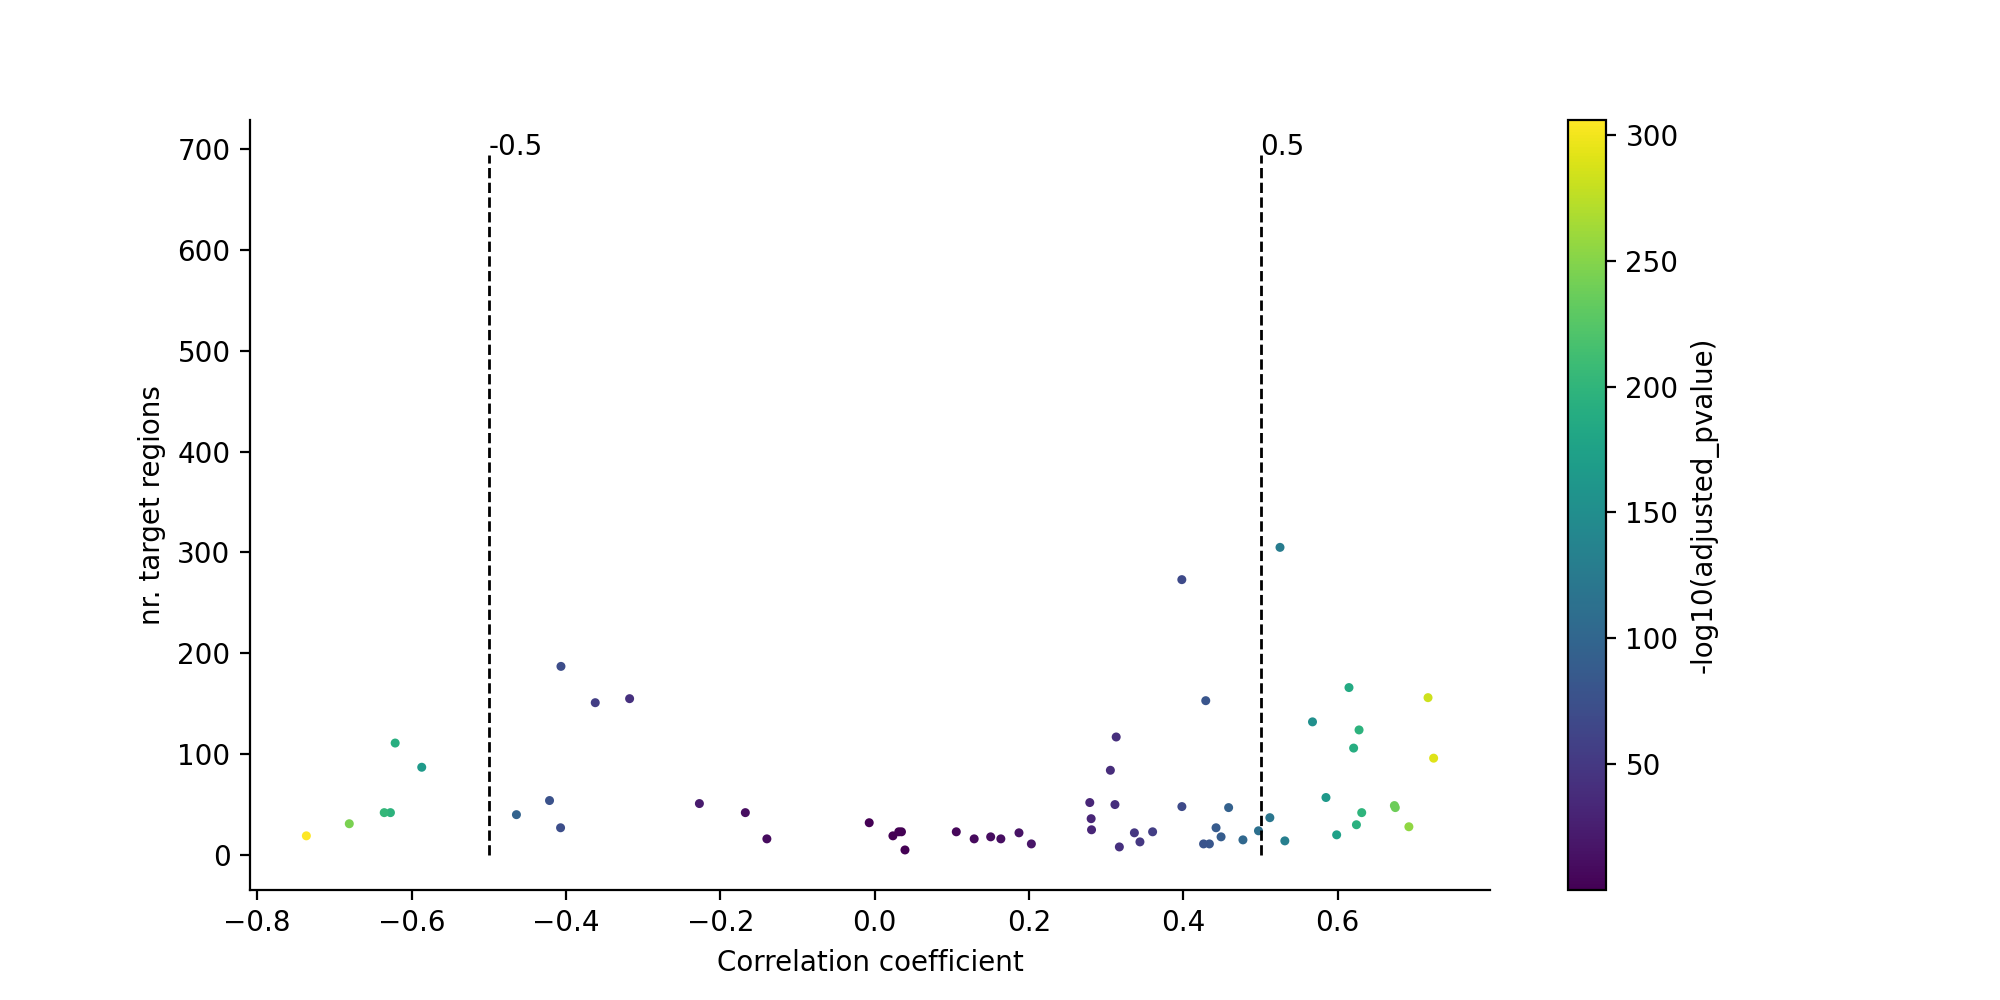

In [47]:
import numpy as np
import re

# Get number of targets, the rho, and adjusted p-vals for the eRegulons
n_targets = [int(re.search(r'\((\d+)r\)', x).group(1)) for x in scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based']['Cistrome']]
rho = scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based']['Rho'].to_list()
adj_pval = scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based']['Adjusted_p-value'].to_list()

# Correlation threshold to select eRegulons
thresholds = {
        'rho': [-0.5, 0.5],
        'n_targets': 0
}

# Create plot of correlation coefficient and number of target regions
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (10, 5))
sc = ax.scatter(rho, n_targets, c = -np.log10(adj_pval), s = 5)
ax.set_xlabel('Correlation coefficient')
ax.set_ylabel('nr. target regions')
ax.vlines(x = thresholds['rho'], ymin = 0, ymax = max(n_targets), color = 'black', ls = 'dashed', lw = 1)
ax.text(x = thresholds['rho'][0], y = max(n_targets), s = str(thresholds['rho'][0]))
ax.text(x = thresholds['rho'][1], y = max(n_targets), s = str(thresholds['rho'][1]))
sns.despine(ax = ax)
fig.colorbar(sc, label = '-log10(adjusted_pvalue)', ax = ax)
plt.show()

In [48]:
# Select certain eRegulons based on the filter criteria
selected_cistromes = scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based'].loc[
        np.logical_or(
                scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based']['Rho'] > thresholds['rho'][1],
                scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based']['Rho'] < thresholds['rho'][0]
        )]['Cistrome'].to_list()
selected_eRegulons = [x.split('_(')[0] for x in selected_cistromes]
selected_eRegulons_gene_sig = [
        x for x in scplus_obj.uns['eRegulon_signatures_filtered']['Gene_based'].keys()
        if x.split('_(')[0] in selected_eRegulons]
selected_eRegulons_region_sig = [
        x for x in scplus_obj.uns['eRegulon_signatures_filtered']['Region_based'].keys()
        if x.split('_(')[0] in selected_eRegulons]


# Save the selected eRegulons in the scplus_obj
scplus_obj.uns['selected_eRegulon'] = {'Gene_based': selected_eRegulons_gene_sig, 'Region_based': selected_eRegulons_region_sig}

# Print the number of selected eRegulons
print(f'selected: {len(selected_eRegulons_gene_sig)} eRegulons')

selected: 34 eRegulons


In [49]:
# Save the scplus object
dill.dump(scplus_obj, open(os.path.join(work_dir, 'scenicplus/scplus_obj.pkl'), 'wb'), protocol=-1)

## 2.4 Create dot plot to save

In [1]:
import pickle
import os

# Set the working directory path
proj_dir = '/gpfs1/home/t/s/tsoleary/projects/heater/'

# Working directory
work_dir = os.path.join(proj_dir, 'data/processed/scenic/')

# Output directory
out_dir = os.path.join(work_dir, 'scenicplus')

# Temp dir
tmp_dir = '/gpfs2/scratch/tsoleary/'

In [2]:
with open(os.path.join(work_dir, 'scenicplus/scplus_obj.pkl'), 'rb') as infile:
    scplus_obj = pickle.load(infile)

In [3]:
from scenicplus.plotting.dotplot import generate_dotplot_df
dotplot_df = generate_dotplot_df(
        scplus_obj = scplus_obj,
        size_matrix = scplus_obj.uns['eRegulon_AUC_filtered']['Region_based'], 
        color_matrix = scplus_obj.to_df('EXP'),
        scale_size_matrix = True,
        scale_color_matrix = True,
        group_variable = 'acc_cell',
        subset_eRegulons = scplus_obj.uns['selected_eRegulon']['Gene_based']
)

# Save to csv for plotting in R
dotplot_df.to_csv(os.path.join(out_dir, 'dotplot.csv'), index = False)

2024-01-10 15:44:31,688 matplotlib.font_manager INFO     Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


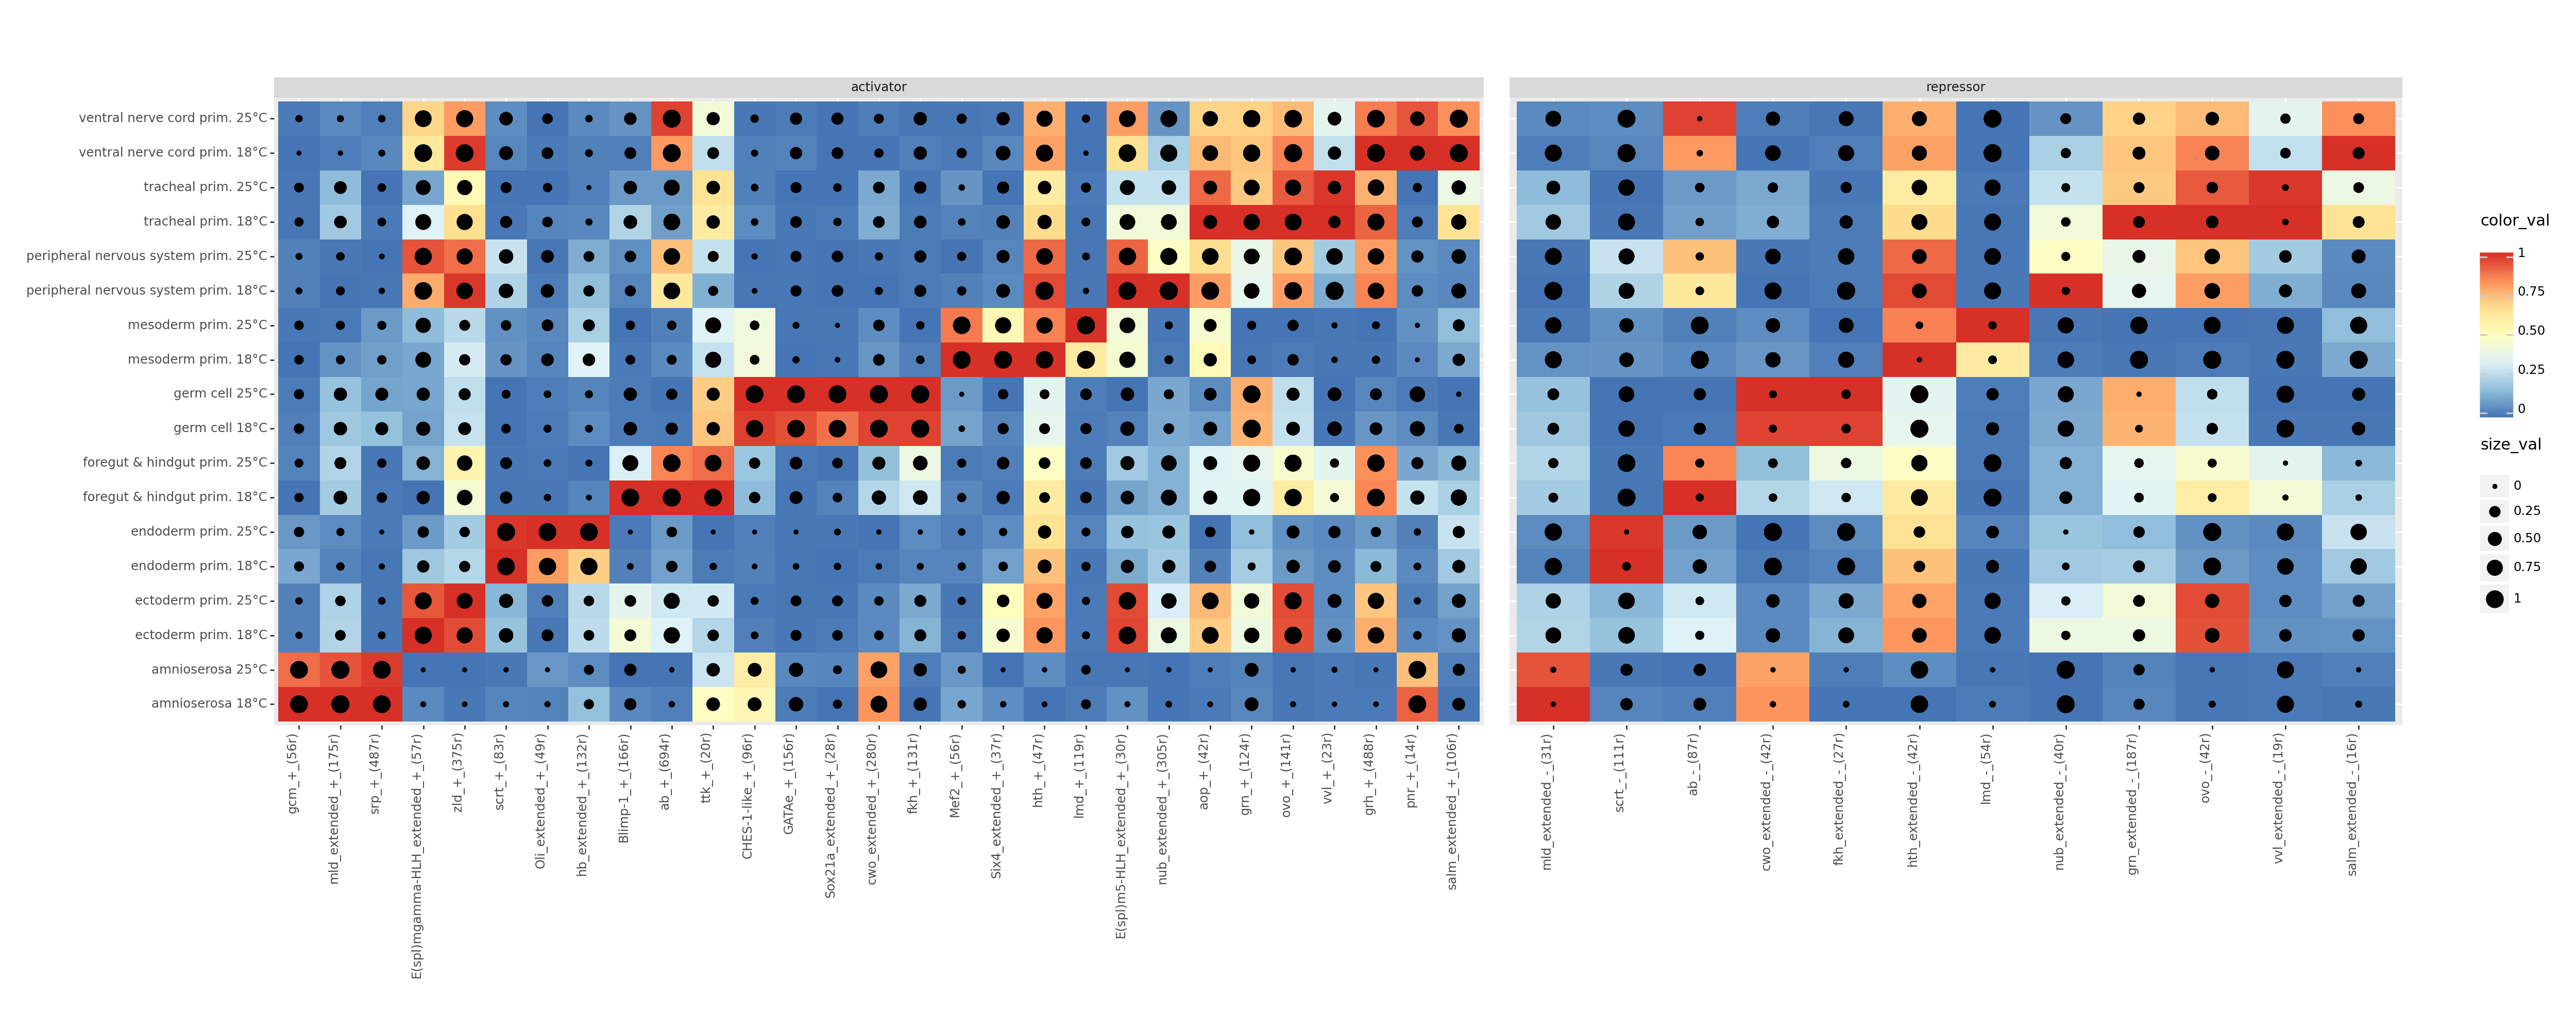

<Figure Size: (2500 x 1000)>

In [53]:
from scenicplus.plotting.dotplot import heatmap_dotplot
heatmap_dotplot(
        scplus_obj = scplus_obj,
        size_matrix = scplus_obj.uns['eRegulon_AUC_filtered']['Region_based'], 
        color_matrix = scplus_obj.to_df('EXP'),
        scale_size_matrix = True,
        scale_color_matrix = True,
        group_variable = 'acc_cell',
        subset_eRegulons = scplus_obj.uns['selected_eRegulon']['Gene_based'],
#         index_order = ['amnioserosa', 'ectoderm prim.', 'endoderm prim.', 
#                        'ventral nerve cord prim.', 'foregut & hindgut prim.', 
#                        'tracheal prim.', 'peripheral nervous system prim.', 
#                        'germ cell'],
        figsize = (25, 10),
        orientation = 'horizontal'
)

In [6]:
scplus_region = scplus_obj.uns['eRegulon_AUC_filtered']['Region_based']
scplus_gene = scplus_obj.uns['eRegulon_AUC_filtered']['Gene_based']

# Save to csv for plotting in R
scplus_region.to_csv(os.path.join(out_dir, 'scplus_region.csv'))
scplus_gene.to_csv(os.path.join(out_dir, 'scplus_gene.csv'))

In [12]:
# Save eRegulon data for R
eregulon_data = scplus_obj.uns['eRegulon_metadata_filtered']
eregulon_data.to_csv(os.path.join(out_dir, 'eRegulon_data.csv'))

In [9]:
from scenicplus.networks import *
import networkx as nx
subset_genes = ['Blimp1', 'ab', 'ttk', 'Mef2', 'Six4']
nx_tables = create_nx_tables(scplus_obj,
                    eRegulon_metadata_key = 'eRegulon_metadata',
                    subset_eRegulons = ['Blimp1', 'ab', 'ttk', 'Mef2', 'Six4'],
                    subset_regions = None,
                    subset_genes = subset_genes,
                    add_differential_gene_expression = True,
                    add_differential_region_accessibility = True,
                    differential_variable = ['GEX_acc_temp'])

/users/t/s/tsoleary/anaconda3/envs/scenicplus/lib/python3.8/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/users/t/s/tsoleary/anaconda3/envs/scenicplus/lib/python3.8/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/users/t/s/tsoleary/anaconda3/envs/scenicplus/lib/python3.8/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


In [10]:
nx_tables

{'Edge': {'TF2R':        TF                   Region Gene_signature_name Region_signature_name  \
  39   Mef2    chr2R:9870446-9870805      Mef2_+_+_(35g)        Mef2_+_+_(56r)   
  40   Mef2    chr2R:9937677-9938387      Mef2_+_+_(35g)        Mef2_+_+_(56r)   
  41   Mef2    chr2R:9929424-9930308      Mef2_+_+_(35g)        Mef2_+_+_(56r)   
  42   Mef2    chr2R:9931568-9932029      Mef2_+_+_(35g)        Mef2_+_+_(56r)   
  43   Mef2    chr2R:9935232-9936628      Mef2_+_+_(35g)        Mef2_+_+_(56r)   
  44   Mef2    chr2R:9867708-9868644      Mef2_+_+_(35g)        Mef2_+_+_(56r)   
  538    ab  chr2L:11188571-11189654       ab_+_+_(202g)         ab_+_+_(694r)   
  539    ab  chr2L:11206641-11207192       ab_+_+_(202g)         ab_+_+_(694r)   
  540    ab  chr2L:11249412-11249792       ab_+_+_(202g)         ab_+_+_(694r)   
  541    ab  chr2L:11362925-11363257       ab_+_+_(202g)         ab_+_+_(694r)   
  542    ab  chr2L:11310550-11311310       ab_+_+_(202g)         ab_+_+_(694r)   
